In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.io_utils import *
from utils.opensim_kinematics_utils import *
from utils.data_processing_utils import *
from utils.analysis_utils import *

In [2]:
# define variables

SUBJECT = "Mathieu"
N_CYCLES = 10
N_COMBOS = 15

# landmarks for which only 1 correct marker was placed on the body
MARKERS_WITHOUT_DISPLACEMENT = [
    "LLTHI", "LLEK", "LMEK", "LLSHA", "LLM",
    "LMM", "LHEE", "LMT2", "LMT5", "RLTHI", "RLEK", "RMEK", "RLSHA", "RLM", "RMM",
    "RHEE", "RMT2", "RMT5", "C7", "T10", "XIPH", "JN"]

# landmarks for which both correct and 4 displaced markers were placed on the body
MARKERS_WITH_DISPLACEMENT = ["RASIS", "LASIS", "RPSIS", "LPSIS"]

ALL_MARKERS = MARKERS_WITH_DISPLACEMENT + MARKERS_WITHOUT_DISPLACEMENT

MARKERSET_FILE = "example_markerset_files/HMB2_MODEL_markers.xml"

# for reproducibility here we define the 15 combinations of displacements,
# but if not defined, they can be generated randomly
COMBOS = [['RASIS270', 'LASIS0', 'RPSIS90', 'LPSIS0'], ['RASIS90', 'LASIS270', 'RPSIS90', 'LPSIS0'],
          ['RASIS270', 'LASIS270', 'RPSIS270', 'LPSIS90'], ['RASIS270', 'LASIS270', 'RPSIS270', 'LPSIS'],
          ['RASIS270', 'LASIS90', 'RPSIS270', 'LPSIS180'], ['RASIS0', 'LASIS90', 'RPSIS', 'LPSIS0'],
          ['RASIS', 'LASIS0', 'RPSIS180', 'LPSIS0'], ['RASIS90', 'LASIS0', 'RPSIS180', 'LPSIS270'],
          ['RASIS90', 'LASIS0', 'RPSIS', 'LPSIS0'], ['RASIS270', 'LASIS0', 'RPSIS0', 'LPSIS270'],
          ['RASIS90', 'LASIS90', 'RPSIS180', 'LPSIS90'], ['RASIS270', 'LASIS', 'RPSIS', 'LPSIS270'],
          ['RASIS270', 'LASIS270', 'RPSIS90', 'LPSIS0'], ['RASIS180', 'LASIS90', 'RPSIS90', 'LPSIS270'],
          ['RASIS90', 'LASIS0', 'RPSIS', 'LPSIS']]

KINEMATICS = ["pelvis_tilt", "pelvis_list", "pelvis_rotation", "hip_flexion_r", "hip_adduction_r", "hip_rotation_r", "knee_angle_r", "ankle_angle_r",
 "subtalar_angle_r", "hip_flexion_l", "hip_adduction_l", "hip_rotation_l", "knee_angle_l", "ankle_angle_l",
 "subtalar_angle_l"]

C3D_CALIB_FILE = os.path.join("example_c3d_files", f"Calibration_{SUBJECT}.c3d")
C3D_WALK_FILE = os.path.join("example_c3d_files", f"Walk_{SUBJECT}.c3d")
GAIT_EVENT_FILE = f"gait_events_{SUBJECT}.csv" # gait event file corresponding to walk c3d file

RESULTS_FOLDER = f"test_caren_displacements_{SUBJECT}"

TEMPLATE_SCALING_SETUP_FILE = "template_scaling_setup.xml"

In [3]:
os.makedirs(RESULTS_FOLDER, exist_ok=True)  

# Part 1: Groundtruth
2 important files resulting from this code and used for evaluation of pipeline:
- point_kin_groundtruth_walking_dynamic.trc : GT marker coordinates during walking trial, after point kinematics step (mandatory for comparison with corrected files that rely on point kinematics (see details explanation in STEP 3))
- point_kin_groundtruth_walking_dynamic_motion.mot : GT joint angles during walking trial, after point kinematics step

In [4]:
# STEP 1: SCALE GT MODEL WITH .c3d CALIB FILE, BASED ONLY ON COORDINATES OF GT MARKERS
scaling("groundtruth",
        RESULTS_FOLDER,
        ALL_MARKERS,
        TEMPLATE_SCALING_SETUP_FILE,
        MARKERSET_FILE,
        c3d_calib_file=C3D_CALIB_FILE)

path_to_gt_scaled_model = os.path.join(RESULTS_FOLDER, "groundtruth" + "_scaled_model_markers.osim")

# STEP 2: INVERSE KINEMATICS ON .c3d WALK FILE, BASED ONLY ON COORDINATES OF GT MARKERS
# --> this gives a .mot file that we will use to do point kinematics of GT markers (see explanation later)
(start_time, stop_time) = inverse_kinematics("groundtruth_walking",
                   "dynamic",
                   ALL_MARKERS,
                   MARKERSET_FILE,
                   path_to_gt_scaled_model,
                   RESULTS_FOLDER,
                   c3d_dynamic_file=C3D_WALK_FILE,
                   n_cycles=N_CYCLES,
                   gait_event_file = GAIT_EVENT_FILE)
path_to_gt_walk_motion = os.path.join(RESULTS_FOLDER, "groundtruth_walking"+"_dynamic_motion.mot")

# STEP 3: POINT KINEMATICS WITH GT MARKERSET ON .MOT FILE RESULTING FROM PREVIOUS INVERSE KINEMATICS STEP
# this might seem useless because we already have the gt .trc file, but as we want to compare the .trc and .mot files of the groundtruth and of the corrected model we need to be sure that they have been through the same steps in OpenSim
# more precisely, to get the corrected .trc and .mot files, a pointkin step will be required and induces a slight shift in all coordinates
# thus, to induce the same shift in the gt data, we also include the pointkin step here
# we then redo an inverse kinematic step (STEP 4) on the gt .trc file obtained from the point kinematics in this step
# --> this gives a .trc file that we will use to compare the marker coordinates with the ones in the displaced and corrected .trc files
point_kinematics (f"point_kin_groundtruth_walking",
                      "dynamic",
                      MARKERSET_FILE,
                      RESULTS_FOLDER,
                      path_to_gt_scaled_model,
                      path_to_gt_walk_motion,
                      gait_event_file=GAIT_EVENT_FILE,
                      n_cycles=N_CYCLES)
path_to_gt_point_kin_trc = os.path.join(RESULTS_FOLDER, "point_kin_groundtruth_walking_dynamic.trc")

# STEP 4: INVERSE KINEMATICS ON .trc WALK FILE OBTAINED FROM POINT KINEMATICS, BASED ONLY ON COORDINATES OF GT MARKERS
# --> this gives a .mot file that we will use compare the kinematics from the GT with the kinematics obtained before and after correction
(start_time, stop_time) = inverse_kinematics(f"point_kin_groundtruth_walking",
                   "dynamic",
                   ALL_MARKERS,
                   MARKERSET_FILE,
                   path_to_gt_scaled_model,
                   RESULTS_FOLDER,
                   trc_dynamic_file=path_to_gt_point_kin_trc,
                   n_cycles=N_CYCLES,
                   gait_event_file = GAIT_EVENT_FILE)
path_to_gt_point_kin_motion = os.path.join(RESULTS_FOLDER, "point_kin_groundtruth_walking_dynamic_motion.mot")

700
0 100
✅ Conversion terminée : test_caren_displacements_Mathieu\groundtruth_calib_static.trc
8031
79 1136
✅ Conversion terminée : test_caren_displacements_Mathieu\groundtruth_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_groundtruth_walking_dynamic.trc


# Part 2: Generation of coordinates and joint angle files from displaced trials 
Recall: everything is based on 1 single calib.c3d and walk.c3d file, but the displacements were simulated in the caren by adding wrongly placed markers around the gt markers.
these markers are also in the .c3d files, but named RASIS0,90,180,270 for example


30 important files resulting from this code and used for evaluation of pipeline:
- 15 .trc files in  `displaced_pointkin_walk_trcs`: displaced marker coordinates during walking trial, after point kinematics step 
- 15 .mot files in  `displaced_pointkin_walk_motions` : displaced joint angles during walking trial, after point kinematics step

In [5]:
# STEP 0: DEFINE START AND STOP TIME OF WALKING TRIAL, DEPENDING ON THE NUMBER OF GAIT CYCLES
gait_events_df = extract_gait_cycles(GAIT_EVENT_FILE)
gait_events_df = gait_events_df[:N_CYCLES]
start_time = gait_events_df["Time"].iloc[0]
end_time = gait_events_df["Time"].iloc[-1]

# lists to store the displaced marker trace and joint angle files
# that will be used to compare with the GT and files after correction
displaced_pointkin_walk_trcs = []
displaced_pointkin_walk_motions = []


for i, combo in enumerate(COMBOS):

    # STEP 1: GENERATE THE 15 DISPLACED .TRC FILES WITH COORDINATES OF DISPLACED MARKERS AS DEFINED IN THE 15 COMBOS
    # --> this results in 15 displaced .trc files with the coordinates of the markers during the calibration trial and 
    # 15 displaced .trc files with the coordinates of the markers during the walking trial
    path_to_displaced_calib_trc = os.path.join(RESULTS_FOLDER, f"combo{i}_calib_static.trc")
    path_to_displaced_walk_trc = os.path.join(RESULTS_FOLDER, f"combo{i}_walk_dynamic.trc")
    MARKERS_i = MARKERS_WITHOUT_DISPLACEMENT + combo
    convert_c3d_to_trc(C3D_CALIB_FILE, output_trc=path_to_displaced_calib_trc, start_time=0, end_time=1, include_markers=MARKERS_i, markers_to_clean=MARKERS_WITH_DISPLACEMENT)
    convert_c3d_to_trc(C3D_WALK_FILE, output_trc=path_to_displaced_walk_trc, start_time=start_time, end_time=end_time, include_markers=MARKERS_i, markers_to_clean=MARKERS_WITH_DISPLACEMENT)

    # STEP 2: SCALE THE MODEL FOR DAY i WITH .trc CALIB FILE, BASED ON DISPLACED MARKERS OF DAY i
    # --> this will result in 15 slightly different models
    scaling(f"combo{i}",
            RESULTS_FOLDER,
            MARKERS_i,
            TEMPLATE_SCALING_SETUP_FILE,
            MARKERSET_FILE, 
            trc_calib_file = path_to_displaced_calib_trc)
            
    path_to_displaced_scaled_model = os.path.join(RESULTS_FOLDER, f"combo{i}_scaled_model_markers.osim")

    # STEP 3: INVERSE KINEMATICS ON DISPLACED MODEL WITH COORDINATES FROM THE DISPLACED .trc WALKING FILE
    # --> this will result in 15 slightly different .mot files that are going to be used for point kinematics in the next step
    # following the same logic as the ground truth for the comparison of results with corrected files
    # (point kin during correction induces a shift)
    inverse_kinematics(f"combo{i}_walking",
                        "dynamic",
                    MARKERS_i,
                    MARKERSET_FILE,
                    path_to_displaced_scaled_model,
                    RESULTS_FOLDER,
                    n_cycles=N_CYCLES,
                    gait_event_file = GAIT_EVENT_FILE,
                    trc_dynamic_file=path_to_displaced_walk_trc)
    
    path_to_displaced_walk_motion = os.path.join(RESULTS_FOLDER, f"combo{i}_walking_dynamic_motion.mot")

    # STEP 4: POINT KINEMATICS ON DISPLACED MODEL WITH GT MARKERSET ON .MOT FILE RESULTING FROM PREVIOUS INVERSE KINEMATICS STEP
    # --> this gives 15 .trc files that we will use to compare the marker coordinates with the ones in the GT and corrected .trc files
    point_kinematics (f"point_kin_combo{i}_walking",
                        "dynamic",
                        MARKERSET_FILE,
                        RESULTS_FOLDER,
                        path_to_displaced_scaled_model,
                        path_to_displaced_walk_motion,
                        gait_event_file=GAIT_EVENT_FILE,
                        n_cycles=N_CYCLES)
    
    path_to_displaced_pointkin_walk_trc = os.path.join(RESULTS_FOLDER, f"point_kin_combo{i}_walking_dynamic.trc")
    displaced_pointkin_walk_trcs.append(path_to_displaced_pointkin_walk_trc)
    # STEP 5: INVERSE KINEMATICS ON DISPLACED .trc WALK FILE OBTAINED FROM POINT KINEMATICS, BASED  ON COORDINATES OF DISPLACED MARKERS
    # --> this gives 15 .mot files that we will use compare the kinematics from the displaced models with the kinematics in the GT and obtained after correction
    inverse_kinematics(f"point_kin_combo{i}_walking",
                    "dynamic",
                    MARKERS_i,
                    MARKERSET_FILE,
                    path_to_displaced_scaled_model,
                    RESULTS_FOLDER,
                    trc_dynamic_file=path_to_displaced_pointkin_walk_trc,
                    dyn_initial_time = start_time,
                    dyn_final_time = end_time)
    path_to_displaced_pointkin_walk_motion = os.path.join(RESULTS_FOLDER, f"point_kin_combo{i}_walking_dynamic_motion.mot")
    displaced_pointkin_walk_motions.append(path_to_displaced_pointkin_walk_motion)

700
0 100
✅ Conversion terminée : test_caren_displacements_Mathieu\combo0_calib_static.trc
8031
79 1136
✅ Conversion terminée : test_caren_displacements_Mathieu\combo0_walk_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_combo0_walking_dynamic.trc
700
0 100
✅ Conversion terminée : test_caren_displacements_Mathieu\combo1_calib_static.trc
8031
79 1136
✅ Conversion terminée : test_caren_displacements_Mathieu\combo1_walk_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_combo1_walking_dynamic.trc
700
0 100
✅ Conversion terminée : test_caren_displacements_Mathieu\combo2_calib_static.trc
8031
79 1136
✅ Conversion terminée : test_caren_displacements_Mathieu\combo2_walk_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_combo2_walking_dynamic.trc
700
0 100
✅ Conversion terminée : test_caren_displacements_Mathieu\combo3_calib_static.trc
8031
79 1136
✅ Conversion terminée : test_caren_displacements_Mathieu\combo3_walk_dynamic.trc
TR

# Part 3: Correction of coordinates and joint angle files from displaced trials, using an averaged model

30 important files resulting from this code and used for evaluation of pipeline:
- 15 .trc files in  `averaged_pointkin_walk_trcs`: corrected marker coordinates during walking trial, after point kinematics step
- 15 .mot files in  `averaged_pointkin_walk_motions` : corrected joint angles during walking trial, after point kinematics step


In [6]:
averaged_pointkin_walk_trcs = []
averaged_pointkin_walk_motions = []

# STEP 1: RETRIEVE ALL DISPLACED CALIB .trc FILES AND AVERAGE
# --> this results in 1 single averaged .trc calib file
prefixes = tuple(f"combo{i}_calib_static" for i in range(N_COMBOS))
path_to_averaged_calib_trc_file = os.path.join(RESULTS_FOLDER, "average_calib_static.trc")

load_average_and_save_trc_bis(
            folder_path=RESULTS_FOLDER,
            reference_trc_path=os.path.join(RESULTS_FOLDER, "groundtruth_calib_static.trc"),
            output_path=path_to_averaged_calib_trc_file,
            reference_marker_order=ALL_MARKERS,
            startswith=prefixes,
            opensim = False)

# STEP 2: SCALE AVERAGED MODEL BASED ON AVERAGED CALIB .trc FILE
scaling("average",
            RESULTS_FOLDER,
            ALL_MARKERS,
            TEMPLATE_SCALING_SETUP_FILE,
            MARKERSET_FILE,
            trc_calib_file = path_to_averaged_calib_trc_file)
path_to_averaged_scaled_model = os.path.join(RESULTS_FOLDER, "average_scaled_model_markers.osim")

for i in range (N_COMBOS):
    # STEP 3: INVERSE KINEAMTICS ON AVERAGED MODEL WITH MARKER COORDINATES FROM DISPLACED .trc FILES¨
    # --> this gives 15 .mot files of the average model moving according to the displaced coordinates
    inverse_kinematics(f"average_combo{i}_walking",
                   "dynamic",
                   ALL_MARKERS,
                   MARKERSET_FILE,
                   path_to_averaged_scaled_model,
                   RESULTS_FOLDER,
                   trc_dynamic_file=os.path.join(RESULTS_FOLDER, f"combo{i}_walk_dynamic.trc"),
                   dyn_initial_time = start_time,
                   dyn_final_time = end_time)
    path_to_averaged_walk_motion = os.path.join(RESULTS_FOLDER, f"average_combo{i}_walking_dynamic_motion.mot")

    # STEP 4: POINT KINEAMTICS ON MOTION FILE OBTAINED IN THE PREVIOUS INVKIN STEP
    # --> this gives the 15 corrected .trc files of the markers during the walking trial that are going to be compared with gt and displaced traces
    point_kinematics (f"point_kin_average_combo{i}_walking",
                      "dynamic",
                      MARKERSET_FILE,
                      RESULTS_FOLDER,
                      path_to_averaged_scaled_model,
                      path_to_averaged_walk_motion,
                      gait_event_file=GAIT_EVENT_FILE,
                      n_cycles=N_CYCLES)
    path_to_averaged_pointkin_walk_trc = os.path.join(RESULTS_FOLDER, f"point_kin_average_combo{i}_walking_dynamic.trc")
    averaged_pointkin_walk_trcs.append(path_to_averaged_pointkin_walk_trc)

    # STEP 5: INVERSE KINEAMTICS ON THE AVERAGED MODEL WITH MARKER COORDINATES FROM .trc FILE OBTAINED IN PREVIOUS POINTKIN STEP
    # --> this gives the 15 corrected .mot files of during the walking trial that are going to be compared with gt and displaced angles
    inverse_kinematics(f"point_kin_average_combo{i}_walking",
                    "dynamic",
                    ALL_MARKERS,
                    MARKERSET_FILE,
                    path_to_averaged_scaled_model,
                    RESULTS_FOLDER,
                    trc_dynamic_file=path_to_averaged_pointkin_walk_trc,
                    dyn_initial_time = start_time,
                    dyn_final_time = end_time)
    path_to_averaged_pointkin_walk_motion = os.path.join(RESULTS_FOLDER, f"point_kin_average_combo{i}_walking_dynamic_motion.mot")
    averaged_pointkin_walk_motions.append(path_to_averaged_pointkin_walk_motion)


combo0_calib_static.trc
combo10_calib_static.trc
combo11_calib_static.trc
combo12_calib_static.trc
combo13_calib_static.trc
combo14_calib_static.trc
combo1_calib_static.trc
combo2_calib_static.trc
combo3_calib_static.trc
combo4_calib_static.trc
combo5_calib_static.trc
combo6_calib_static.trc
combo7_calib_static.trc
combo8_calib_static.trc
combo9_calib_static.trc
✅ Fichier .trc moyen sauvegardé : test_caren_displacements_Mathieu\average_calib_static.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo0_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo1_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo2_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo3_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo4_walking_dynamic.trc
TRC file saved: test_caren_displacements_Mathieu\point_kin_average_combo5

# Part 4: Evaluation of results - Comparison of marker RMSE and kinematics RMSE between GT-displaced and GT-corrected


=== Global analysis (mean on all markers / day) ===
Mean Error BEFORE correction : 0.0025
Mean Error AFTER correction : 0.0017
t test : t = 11.763, p = 0.0000 --> Significant
Wilcoxon : W = 0.000, p = 0.0001 --> Significant


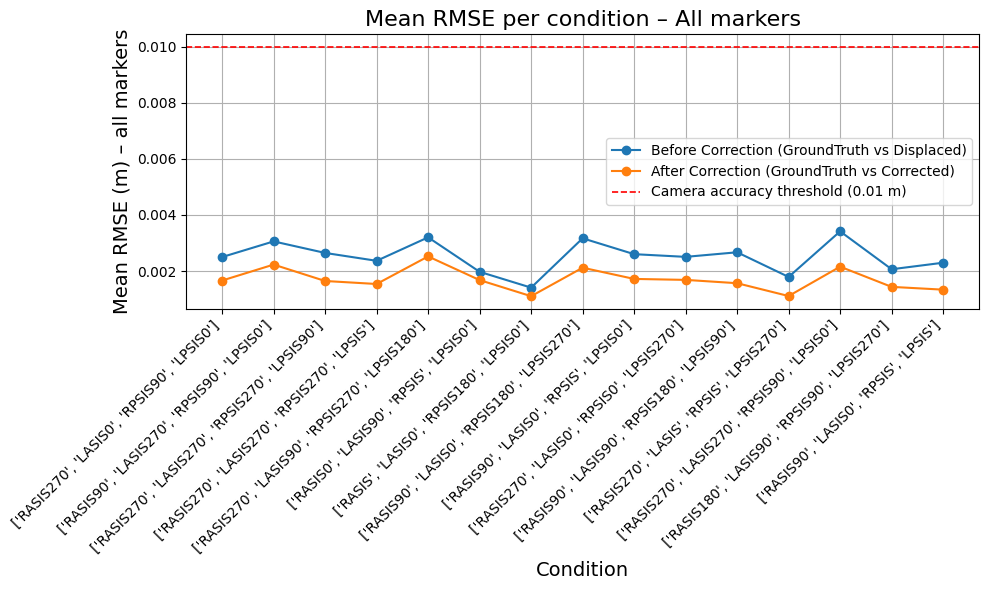


=== Detailed analysis per marker ===

🟢 RASIS
  Mean BEFORE : 0.0086
  Mean AFTER  : 0.0045
  t-test    : t = 7.508, p = 0.0000 → Significant
  Wilcoxon  : W = 0.000, p = 0.0001 → Significant


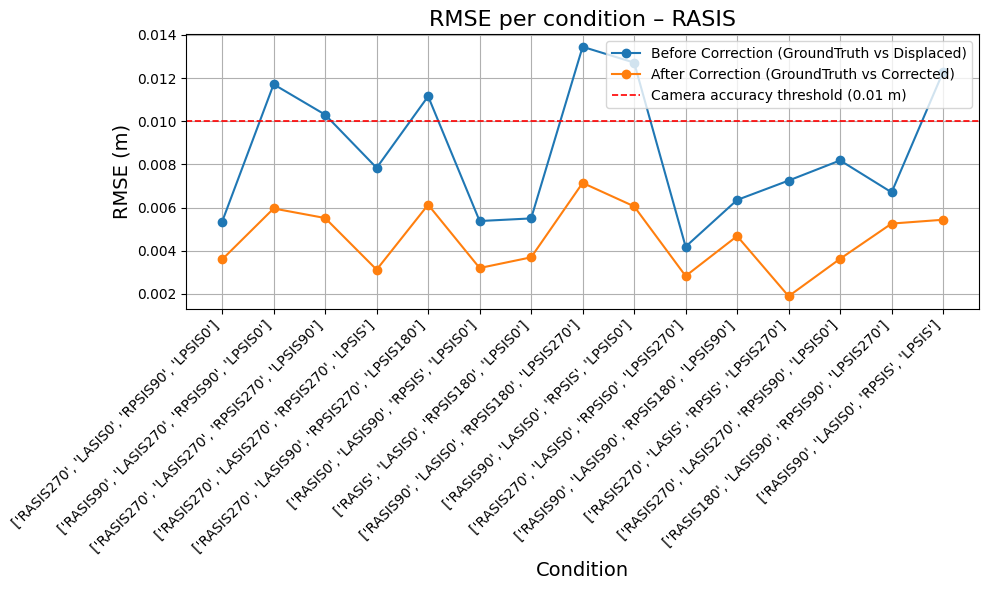


🟢 LASIS
  Mean BEFORE : 0.0058
  Mean AFTER  : 0.0040
  t-test    : t = 4.433, p = 0.0006 → Significant
  Wilcoxon  : W = 6.000, p = 0.0009 → Significant


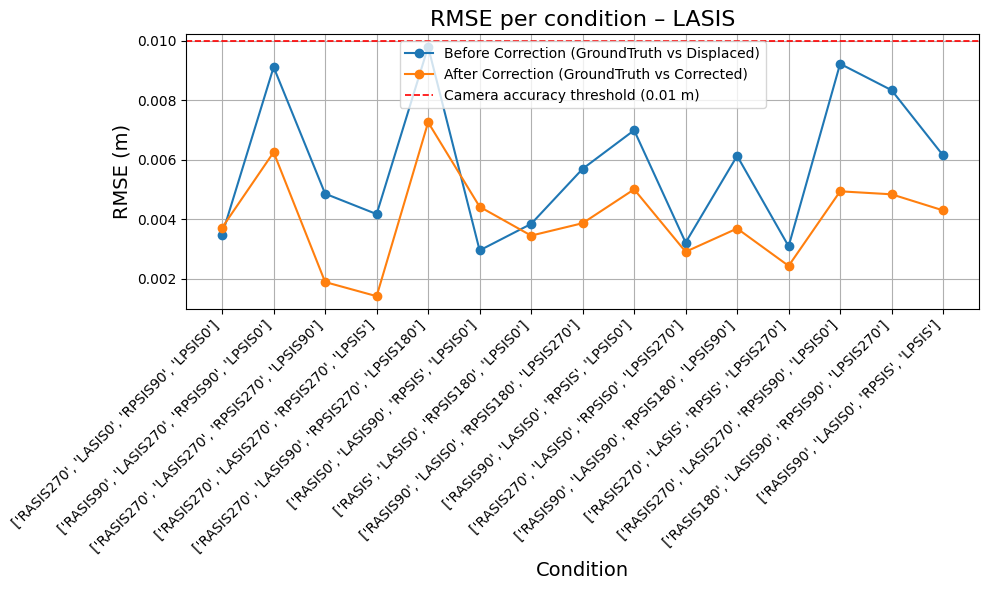


🟢 RPSIS
  Mean BEFORE : 0.0041
  Mean AFTER  : 0.0036
  t-test    : t = 2.187, p = 0.0462 → Significant
  Wilcoxon  : W = 28.000, p = 0.0730 → Not significant


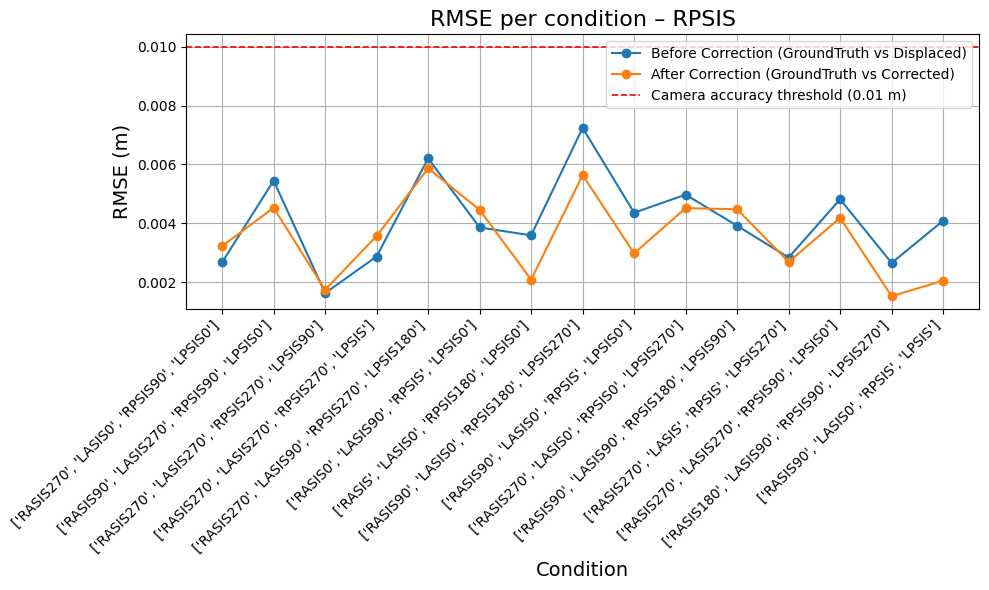


🟢 LPSIS
  Mean BEFORE : 0.0035
  Mean AFTER  : 0.0032
  t-test    : t = 1.380, p = 0.1894 → Not significant
  Wilcoxon  : W = 38.000, p = 0.2293 → Not significant


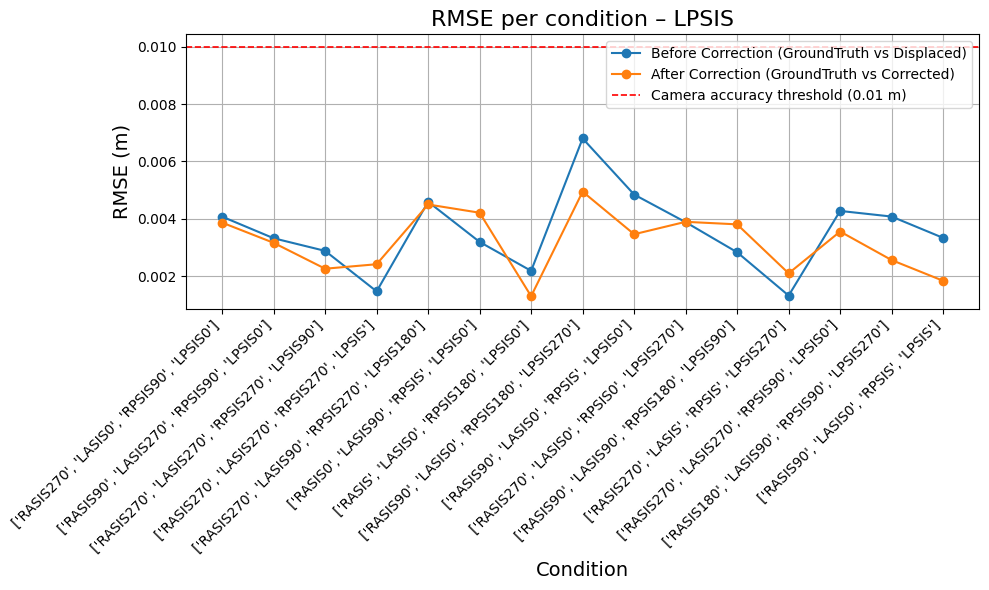


🟢 LLTHI
  Mean BEFORE : 0.0041
  Mean AFTER  : 0.0025
  t-test    : t = 5.692, p = 0.0001 → Significant
  Wilcoxon  : W = 1.000, p = 0.0001 → Significant


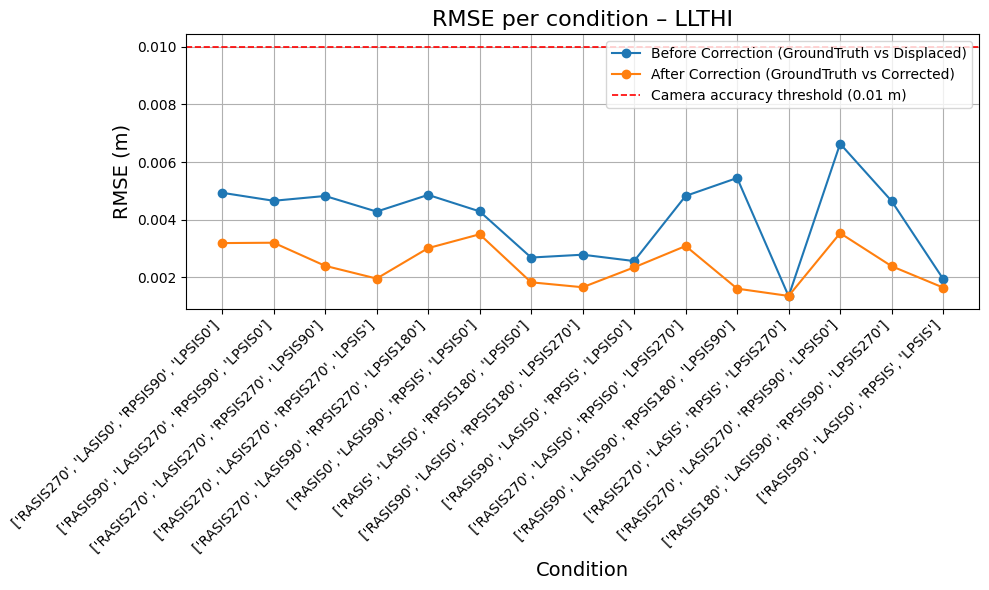


🟢 LLEK
  Mean BEFORE : 0.0032
  Mean AFTER  : 0.0017
  t-test    : t = 4.737, p = 0.0003 → Significant
  Wilcoxon  : W = 5.000, p = 0.0006 → Significant


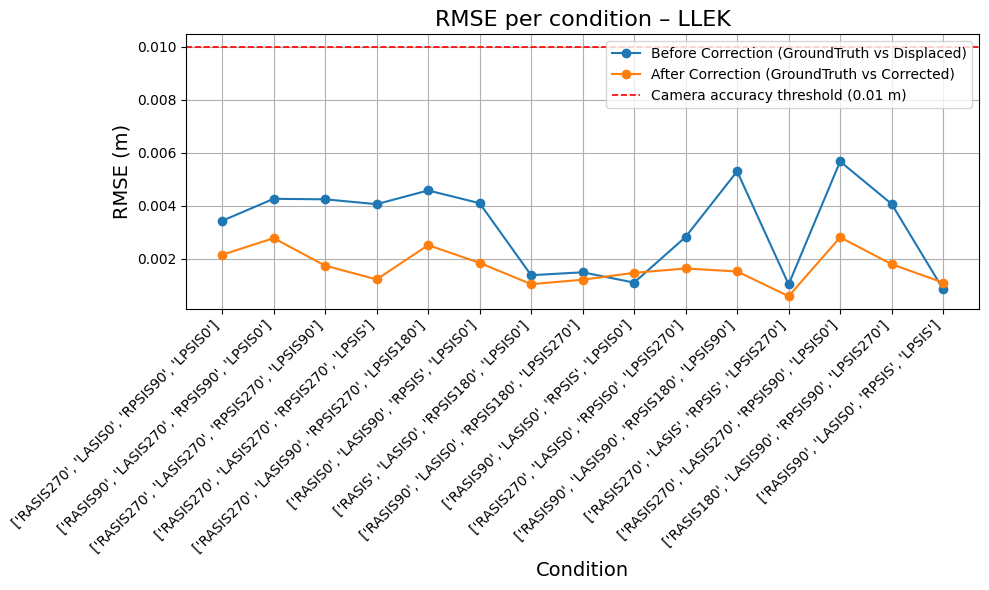


🟢 LMEK
  Mean BEFORE : 0.0030
  Mean AFTER  : 0.0016
  t-test    : t = 4.680, p = 0.0004 → Significant
  Wilcoxon  : W = 3.000, p = 0.0003 → Significant


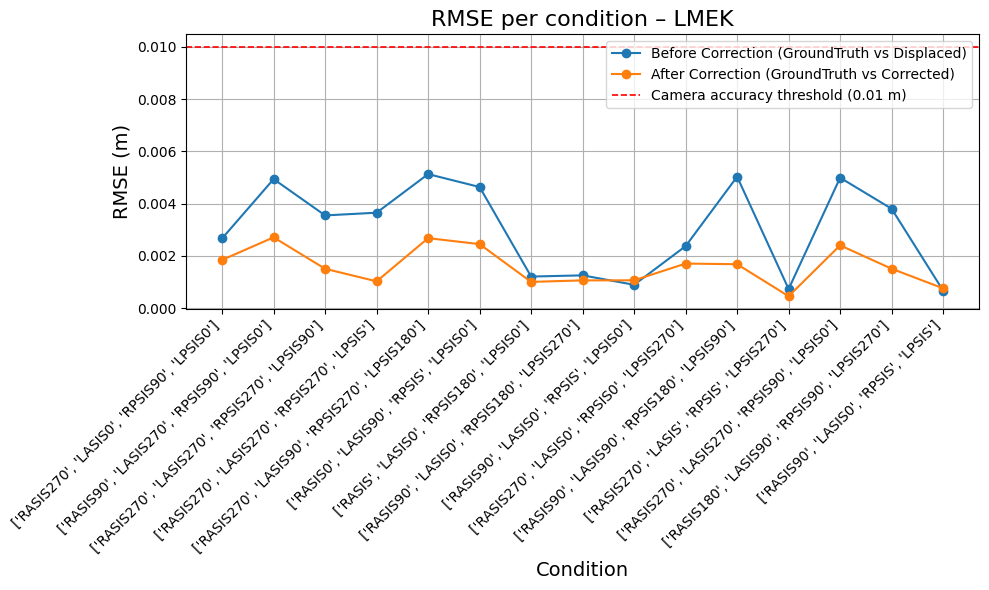


🟢 LLSHA
  Mean BEFORE : 0.0011
  Mean AFTER  : 0.0011
  t-test    : t = -0.150, p = 0.8826 → Not significant
  Wilcoxon  : W = 49.000, p = 0.5614 → Not significant


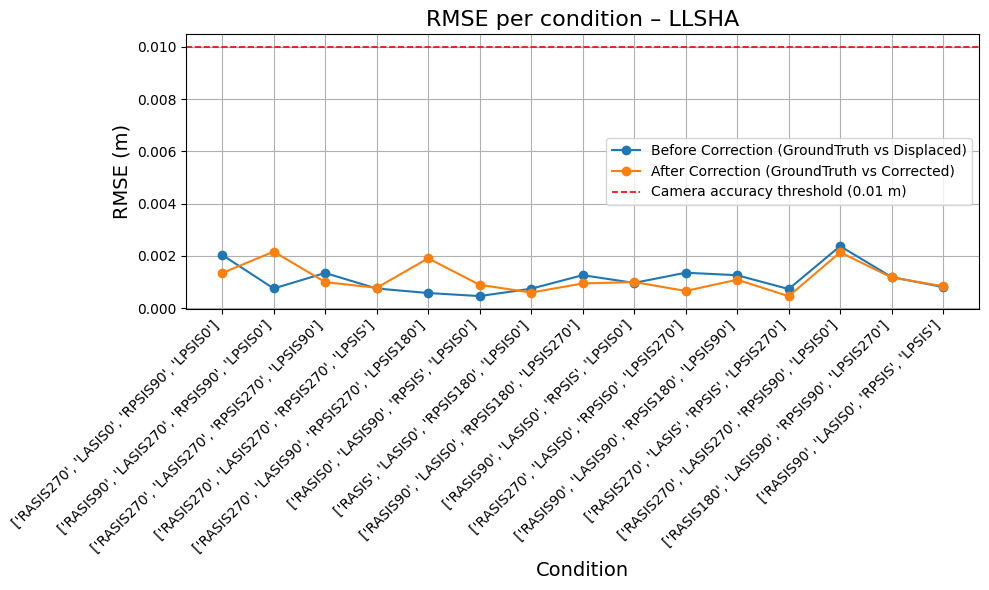


🟢 LLM
  Mean BEFORE : 0.0008
  Mean AFTER  : 0.0008
  t-test    : t = -0.100, p = 0.9220 → Not significant
  Wilcoxon  : W = 52.000, p = 0.6788 → Not significant


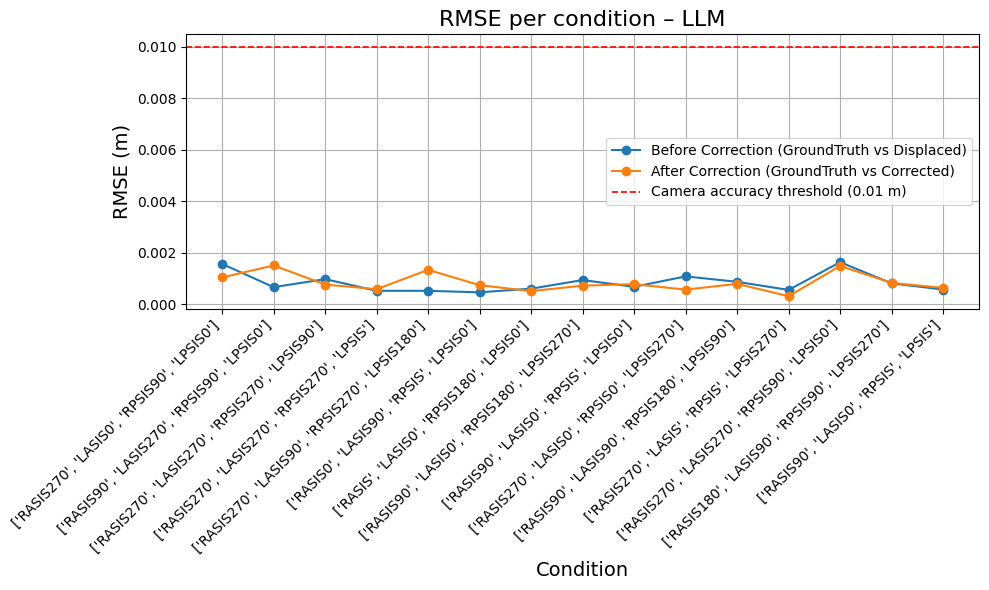


🟢 LMM
  Mean BEFORE : 0.0007
  Mean AFTER  : 0.0008
  t-test    : t = -1.004, p = 0.3325 → Not significant
  Wilcoxon  : W = 56.000, p = 0.8469 → Not significant


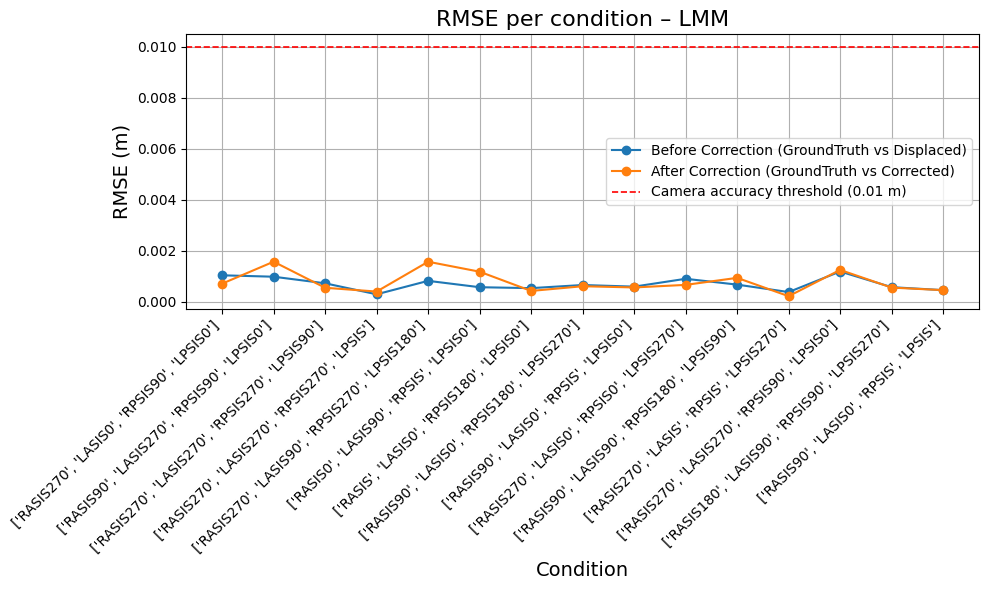


🟢 LHEE
  Mean BEFORE : 0.0009
  Mean AFTER  : 0.0010
  t-test    : t = -0.546, p = 0.5937 → Not significant
  Wilcoxon  : W = 54.000, p = 0.7615 → Not significant


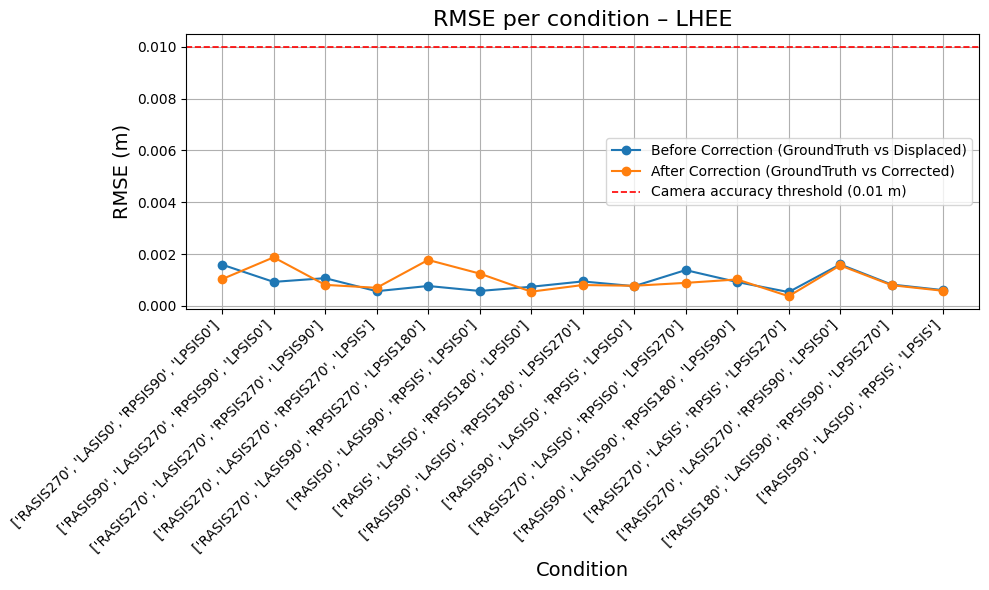


🟢 LMT2
  Mean BEFORE : 0.0004
  Mean AFTER  : 0.0004
  t-test    : t = -0.047, p = 0.9631 → Not significant
  Wilcoxon  : W = 44.000, p = 0.3894 → Not significant


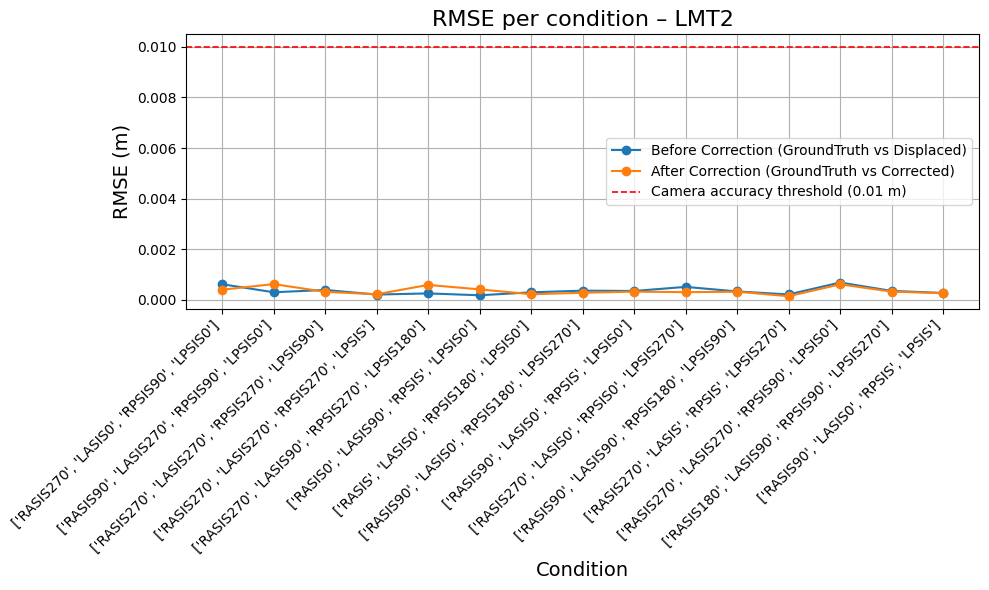


🟢 LMT5
  Mean BEFORE : 0.0005
  Mean AFTER  : 0.0005
  t-test    : t = 0.734, p = 0.4750 → Not significant
  Wilcoxon  : W = 46.000, p = 0.4543 → Not significant


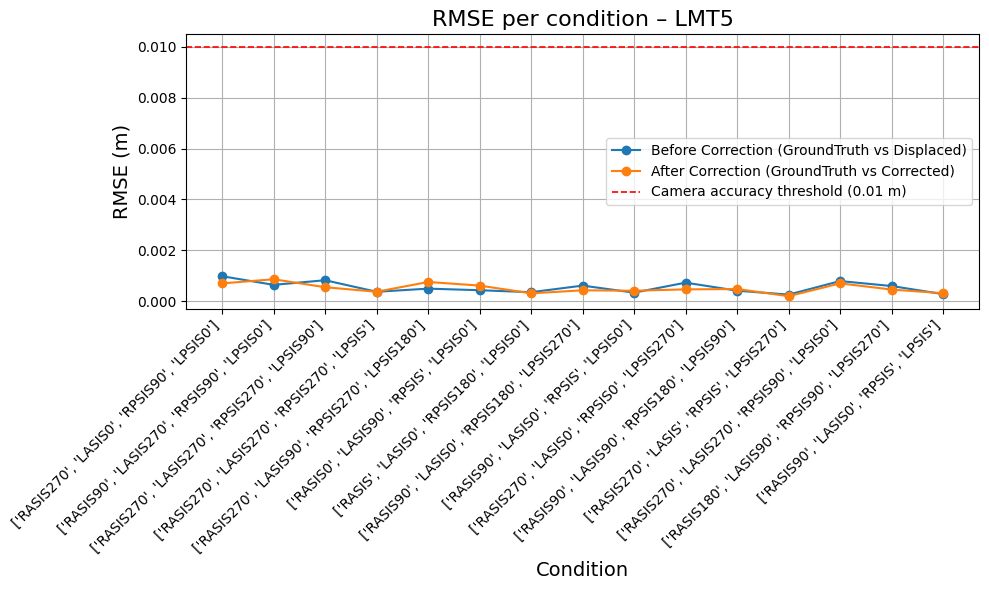


🟢 RLTHI
  Mean BEFORE : 0.0062
  Mean AFTER  : 0.0025
  t-test    : t = 9.147, p = 0.0000 → Significant
  Wilcoxon  : W = 0.000, p = 0.0001 → Significant


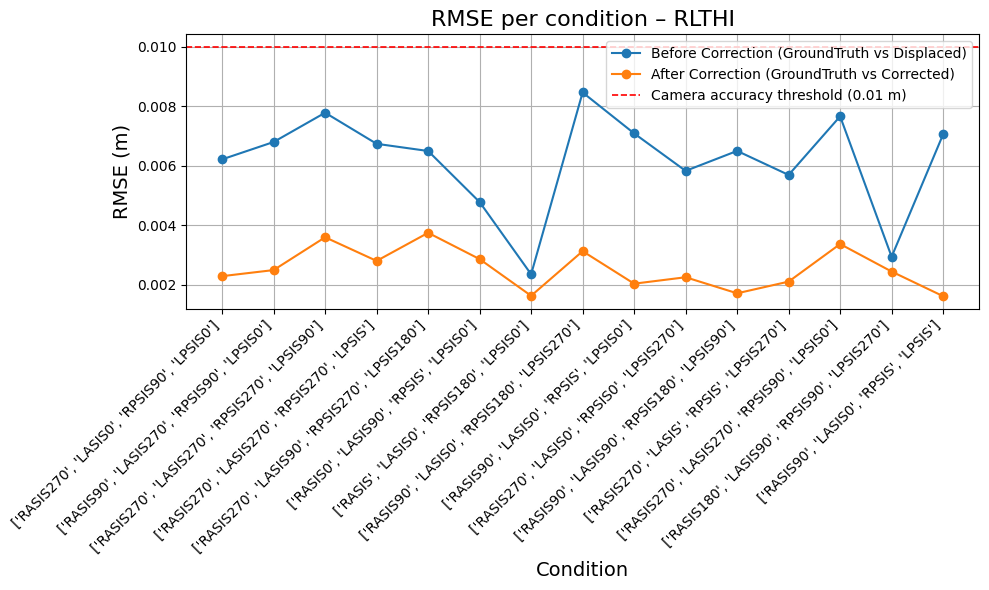


🟢 RLEK
  Mean BEFORE : 0.0055
  Mean AFTER  : 0.0019
  t-test    : t = 7.994, p = 0.0000 → Significant
  Wilcoxon  : W = 0.000, p = 0.0001 → Significant


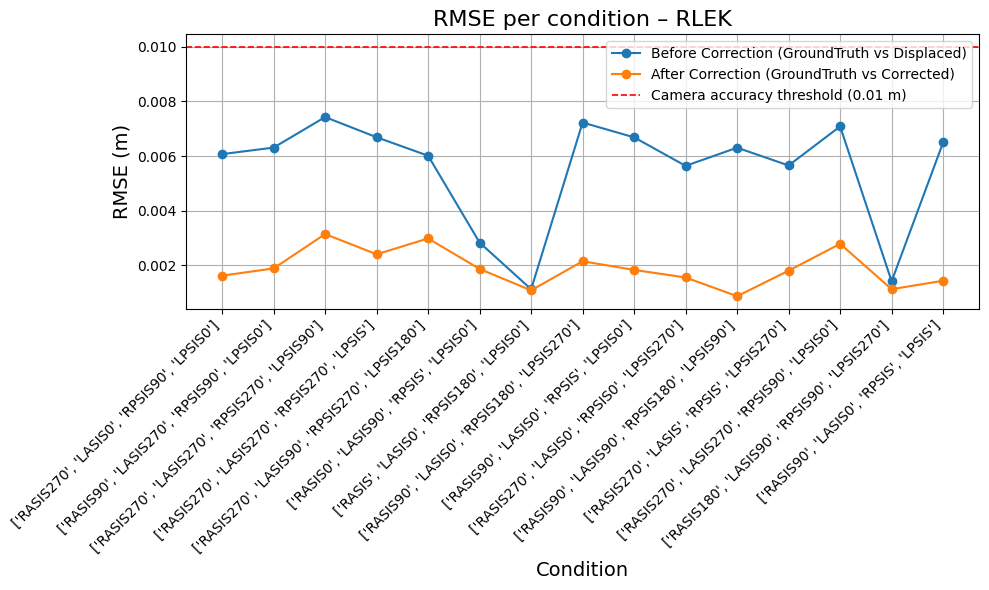


🟢 RMEK
  Mean BEFORE : 0.0058
  Mean AFTER  : 0.0021
  t-test    : t = 7.379, p = 0.0000 → Significant
  Wilcoxon  : W = 1.000, p = 0.0001 → Significant


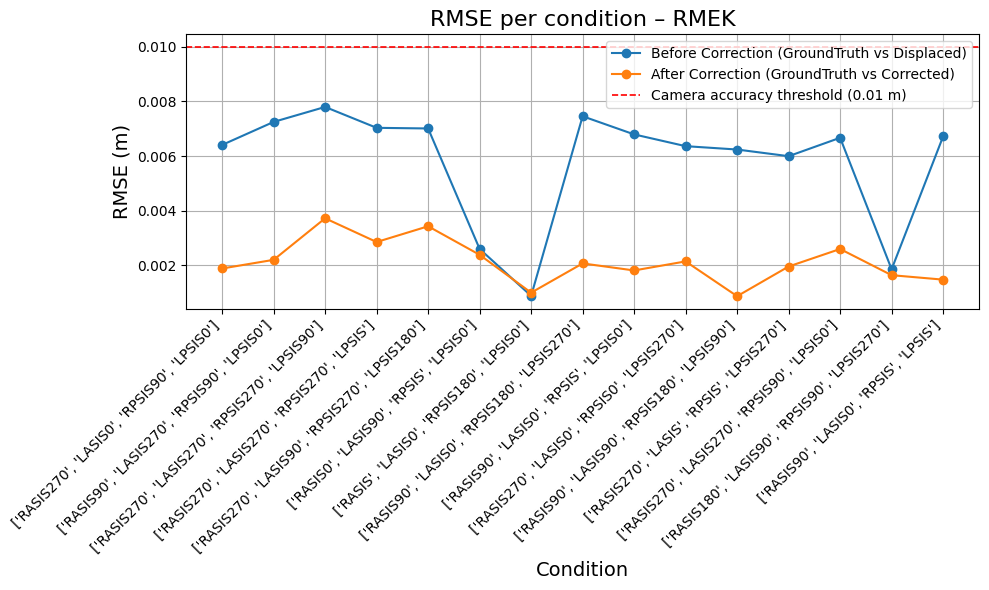


🟢 RLSHA
  Mean BEFORE : 0.0010
  Mean AFTER  : 0.0012
  t-test    : t = -1.922, p = 0.0752 → Not significant
  Wilcoxon  : W = 32.000, p = 0.1205 → Not significant


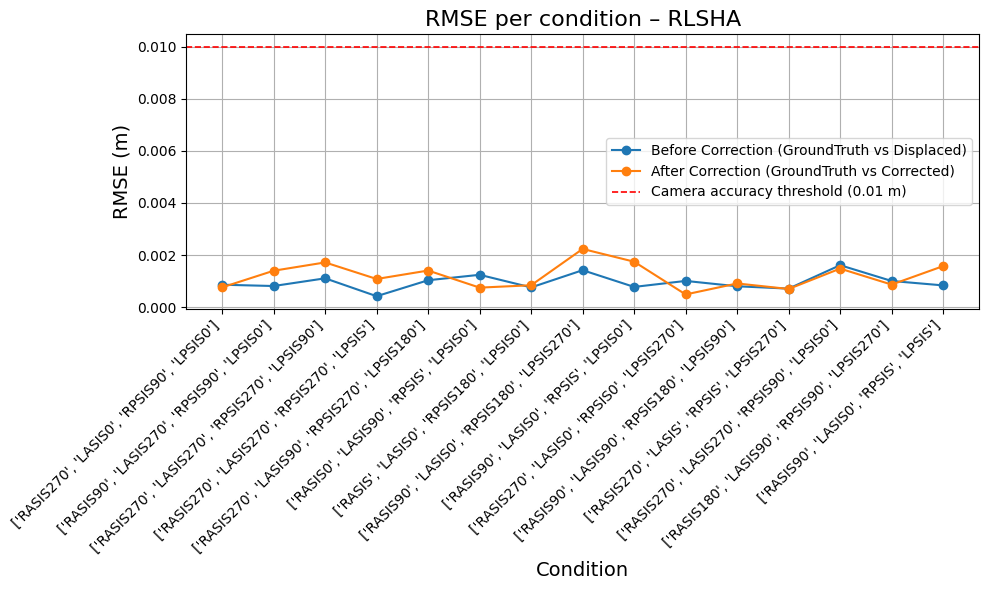


🟢 RLM
  Mean BEFORE : 0.0008
  Mean AFTER  : 0.0009
  t-test    : t = -1.479, p = 0.1612 → Not significant
  Wilcoxon  : W = 37.000, p = 0.2078 → Not significant


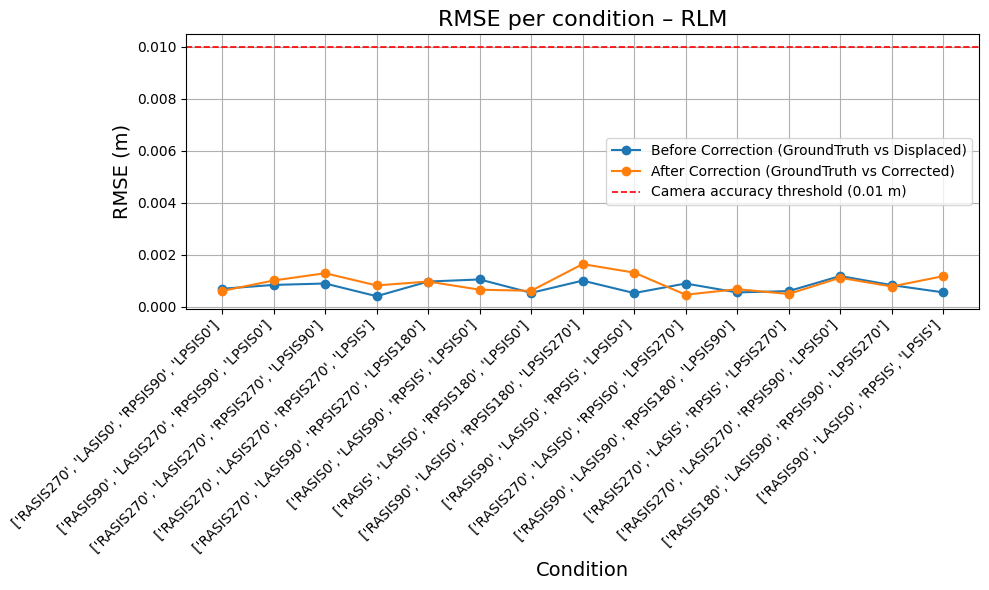


🟢 RMM
  Mean BEFORE : 0.0007
  Mean AFTER  : 0.0010
  t-test    : t = -3.711, p = 0.0023 → Significant
  Wilcoxon  : W = 9.000, p = 0.0020 → Significant


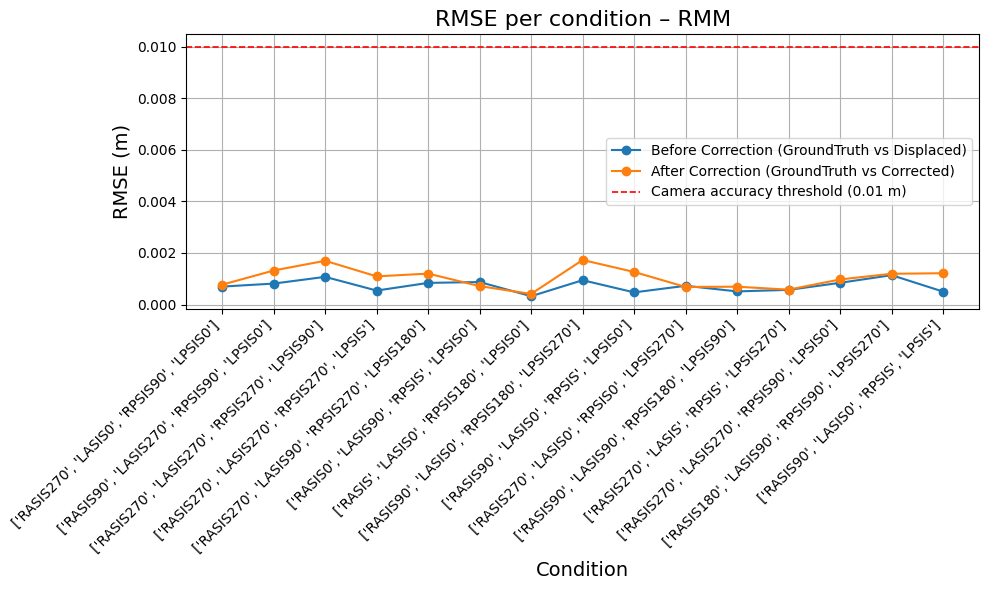


🟢 RHEE
  Mean BEFORE : 0.0009
  Mean AFTER  : 0.0012
  t-test    : t = -3.267, p = 0.0056 → Significant
  Wilcoxon  : W = 15.000, p = 0.0084 → Significant


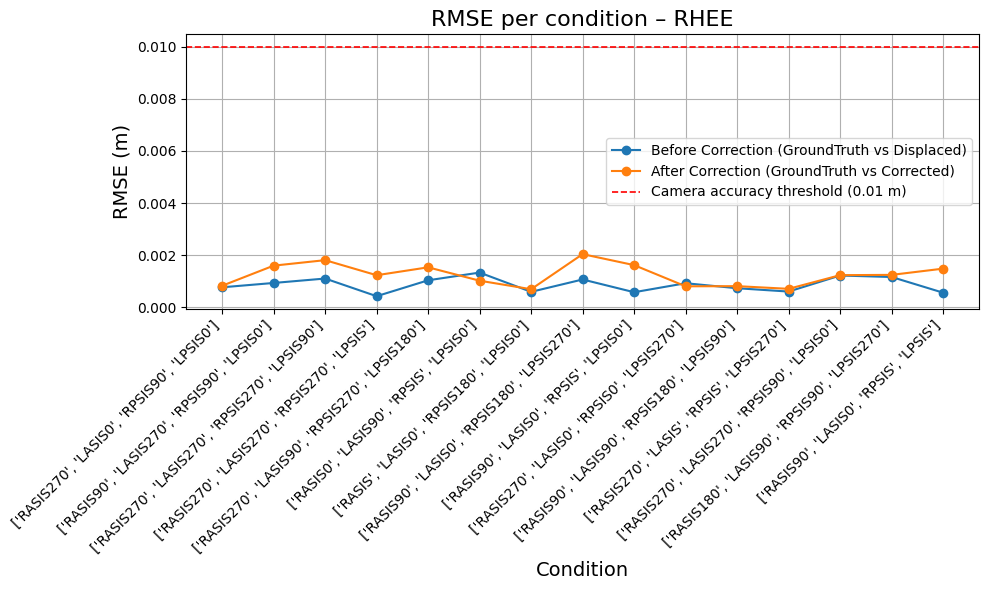


🟢 RMT2
  Mean BEFORE : 0.0003
  Mean AFTER  : 0.0004
  t-test    : t = -1.107, p = 0.2868 → Not significant
  Wilcoxon  : W = 44.000, p = 0.3894 → Not significant


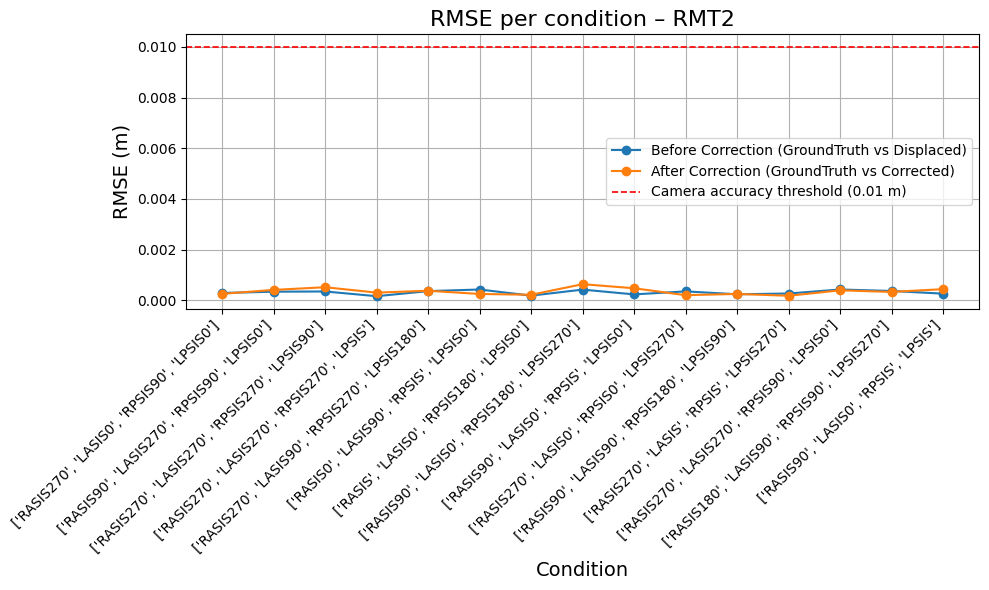


🟢 RMT5
  Mean BEFORE : 0.0004
  Mean AFTER  : 0.0006
  t-test    : t = -4.430, p = 0.0006 → Significant
  Wilcoxon  : W = 7.000, p = 0.0012 → Significant


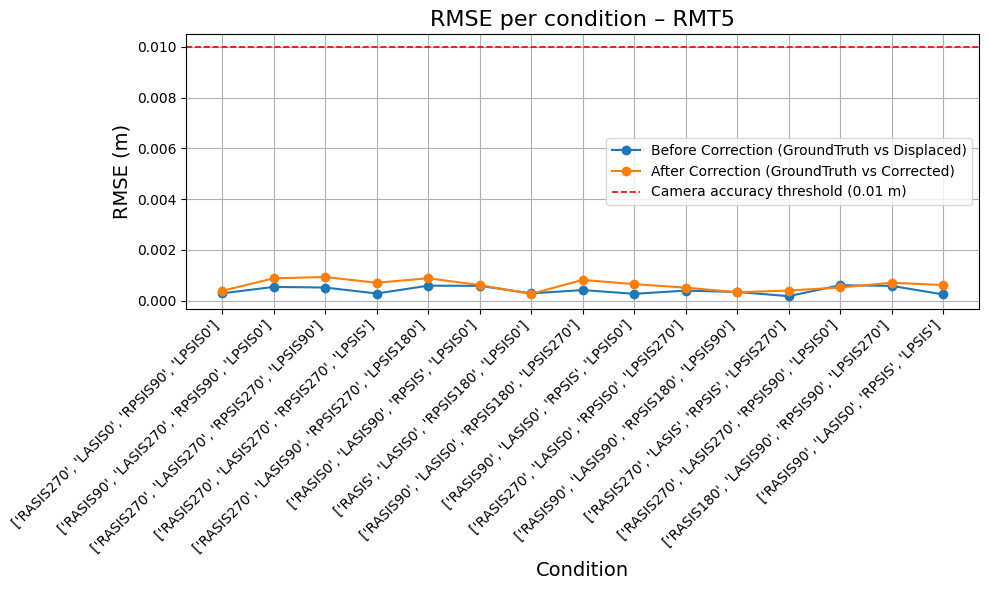


🟢 C7
  Mean BEFORE : 0.0014
  Mean AFTER  : 0.0014
  t-test    : t = -0.217, p = 0.8313 → Not significant
  Wilcoxon  : W = 54.000, p = 0.7615 → Not significant


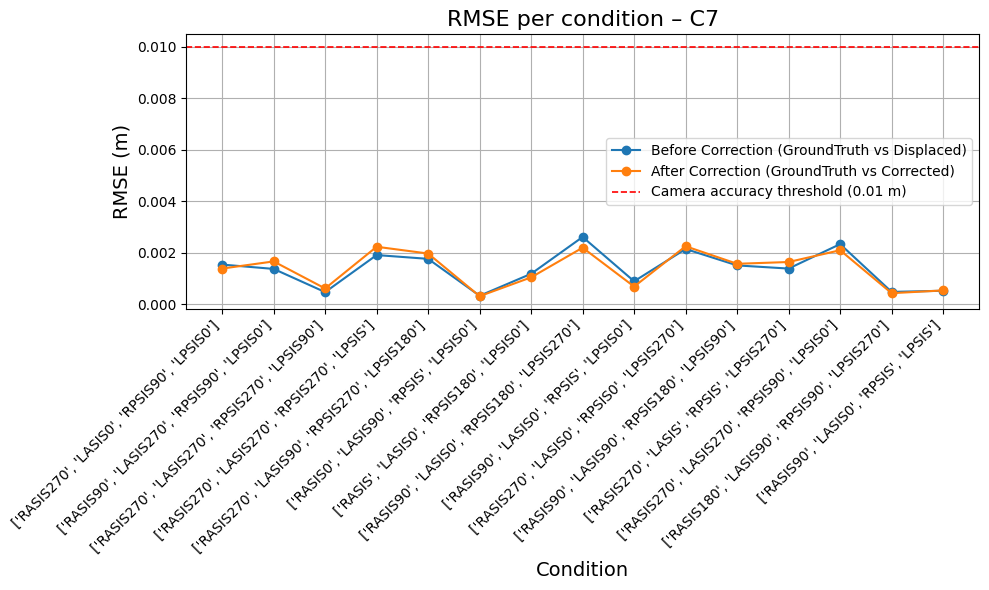


🟢 T10
  Mean BEFORE : 0.0021
  Mean AFTER  : 0.0020
  t-test    : t = 1.657, p = 0.1198 → Not significant
  Wilcoxon  : W = 31.000, p = 0.1070 → Not significant


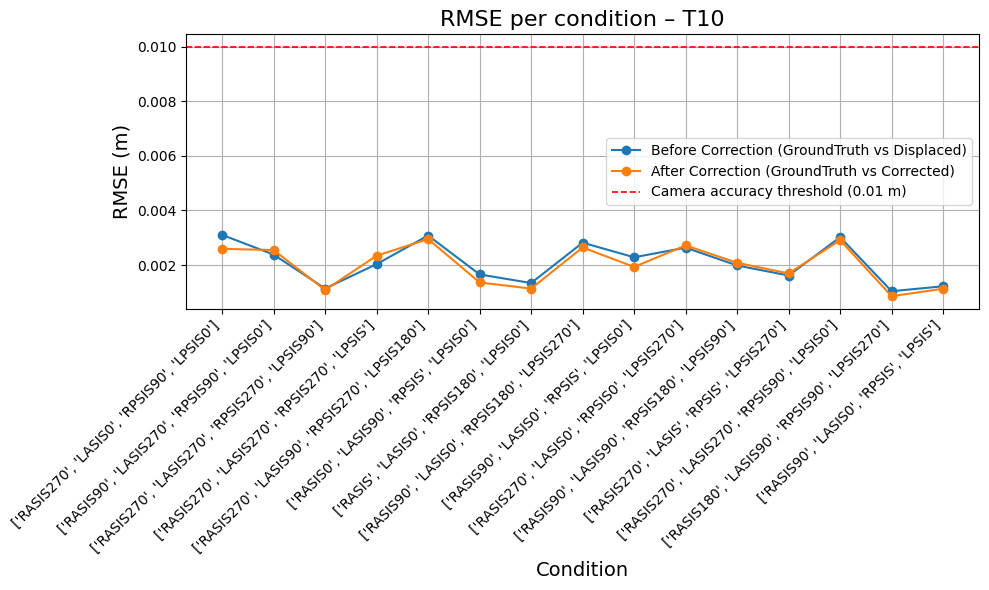


🟢 XIPH
  Mean BEFORE : 0.0021
  Mean AFTER  : 0.0019
  t-test    : t = 3.974, p = 0.0014 → Significant
  Wilcoxon  : W = 9.000, p = 0.0020 → Significant


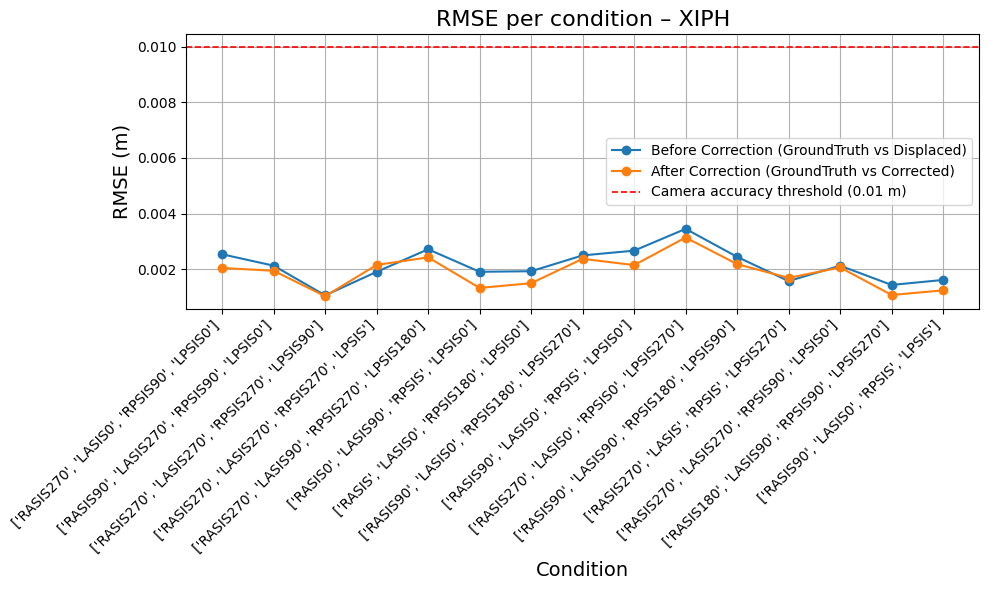


🟢 JN
  Mean BEFORE : 0.0014
  Mean AFTER  : 0.0013
  t-test    : t = 1.237, p = 0.2365 → Not significant
  Wilcoxon  : W = 42.000, p = 0.3303 → Not significant


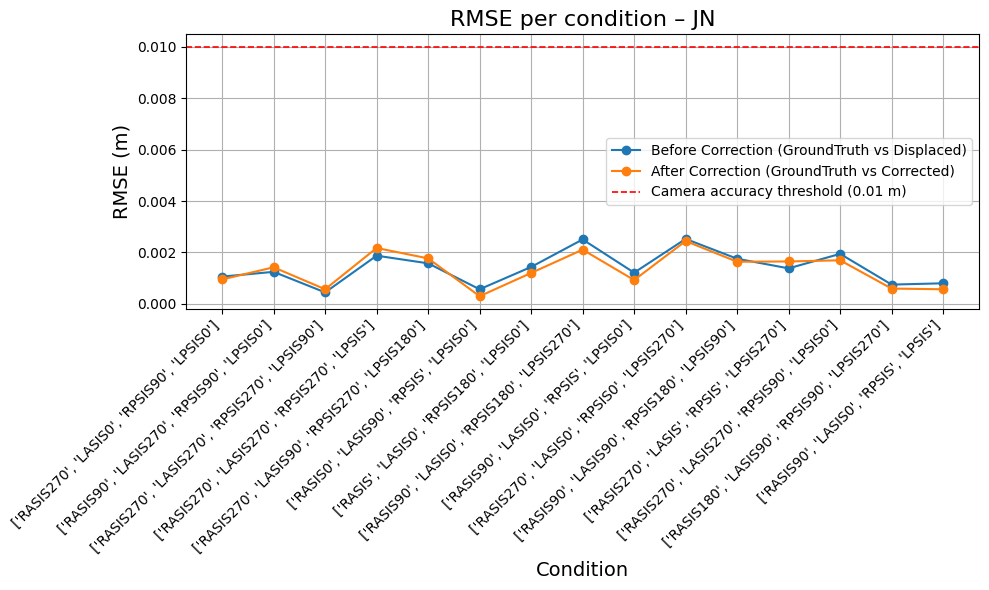


=== Bar Chart: Mean RMSE Before vs After per Marker ===


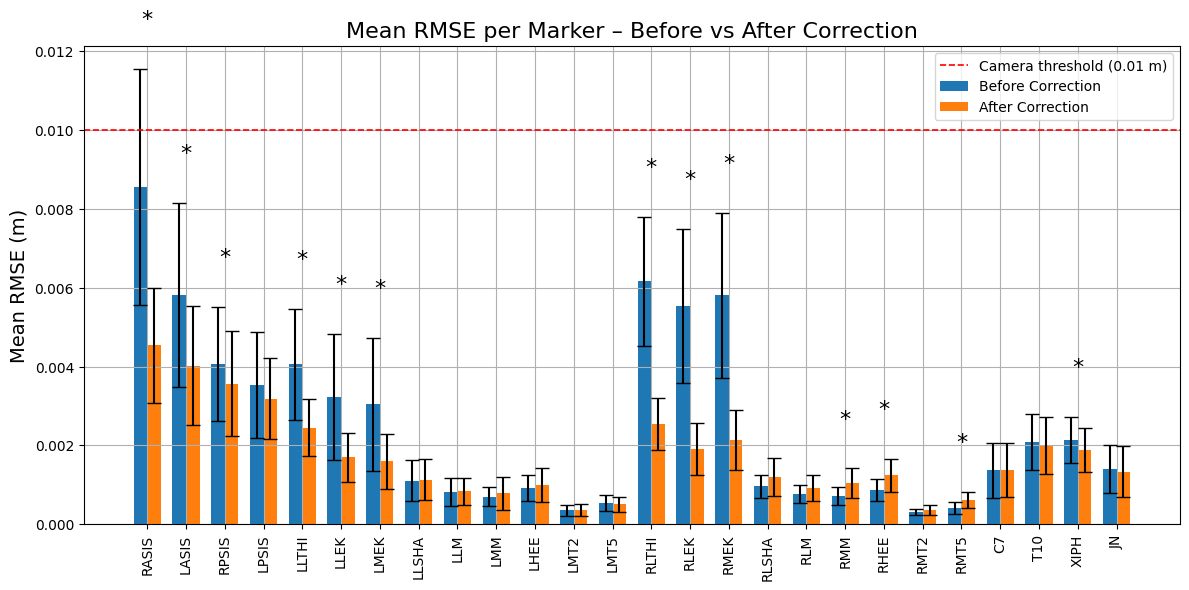

In [7]:
per_marker_b, per_marker_a, global_b, global_a = analyze_correction_effect_per_day_with_marker_details__(
    ground_truth_path=path_to_gt_point_kin_trc,
    files_before = displaced_pointkin_walk_trcs,
    files_after= averaged_pointkin_walk_trcs,
    markers_to_compare=ALL_MARKERS,
    t_min=0.0,
    t_max=10,
    combo_list=COMBOS
)


=== Global Kinematic Analysis ===
Mean Error BEFORE correction : 3.3408
Mean Error AFTER correction : 2.1161
t-test     : t = 8.551, p = 0.0000 → Significant
Wilcoxon   : W = 0.000, p = 0.0001 → Significant


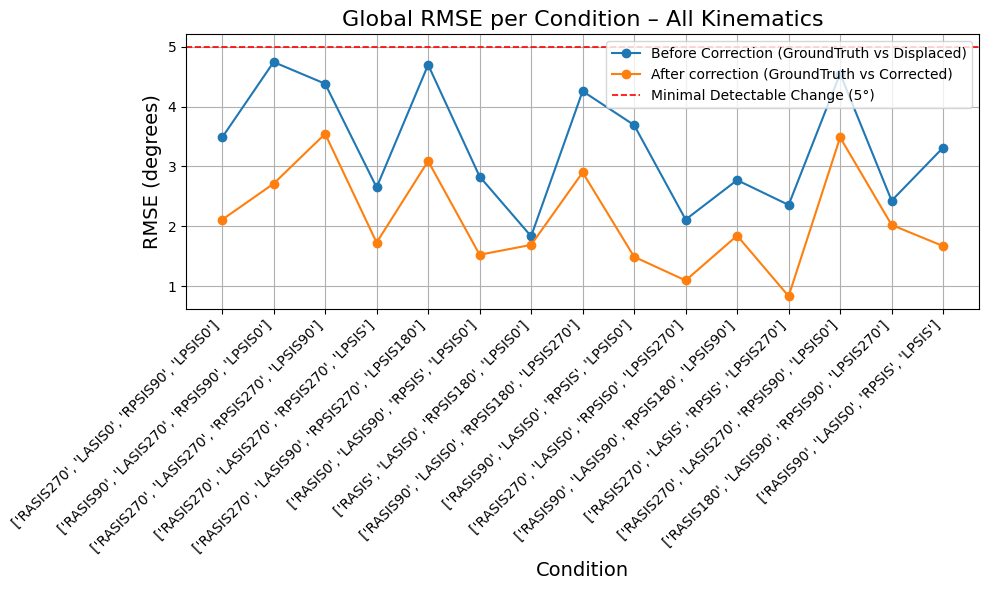


=== Per-Kinematic Analysis ===

🟢 pelvis_tilt
  Mean BEFORE : 7.6309
  Mean AFTER  : 4.4309
  t-test    : t = 4.533, p = 0.0005 → Significant
  Wilcoxon  : W = 3.000, p = 0.0003 → Significant


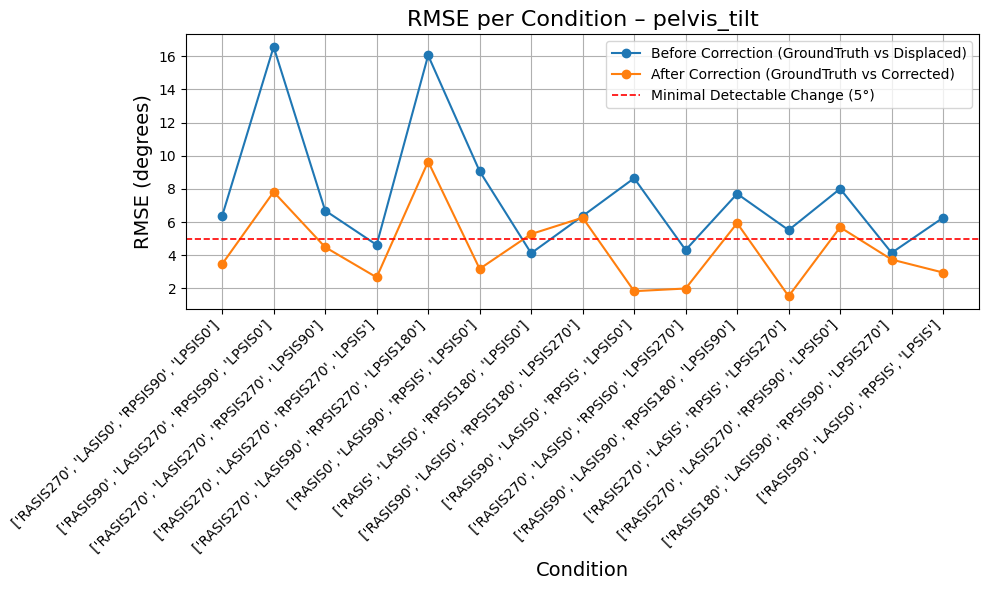


🟢 pelvis_list
  Mean BEFORE : 3.6898
  Mean AFTER  : 1.9308
  t-test    : t = 8.651, p = 0.0000 → Significant
  Wilcoxon  : W = 0.000, p = 0.0001 → Significant


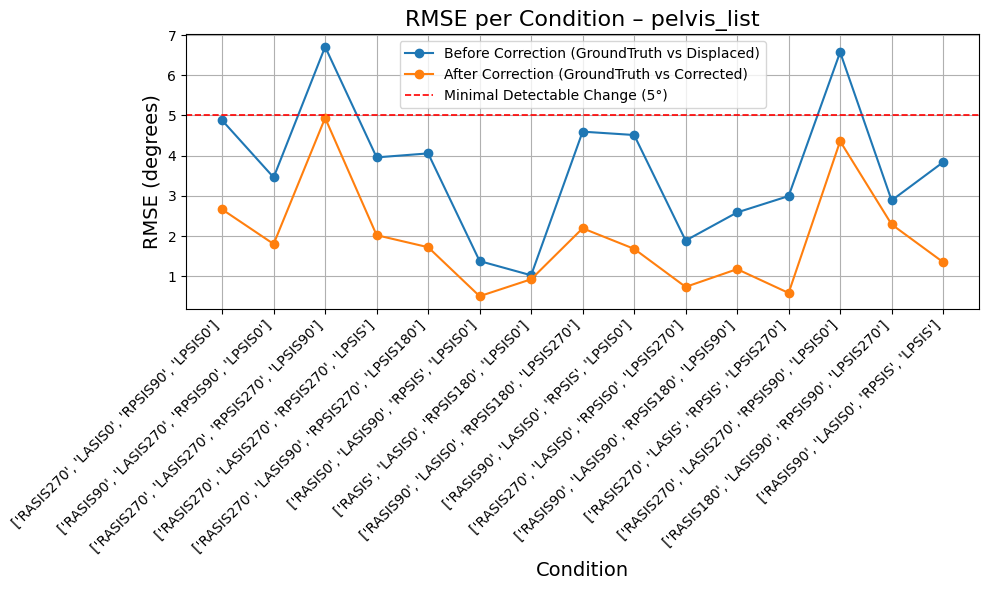


🟢 pelvis_rotation
  Mean BEFORE : 6.2846
  Mean AFTER  : 3.6353
  t-test    : t = 6.124, p = 0.0000 → Significant
  Wilcoxon  : W = 2.000, p = 0.0002 → Significant


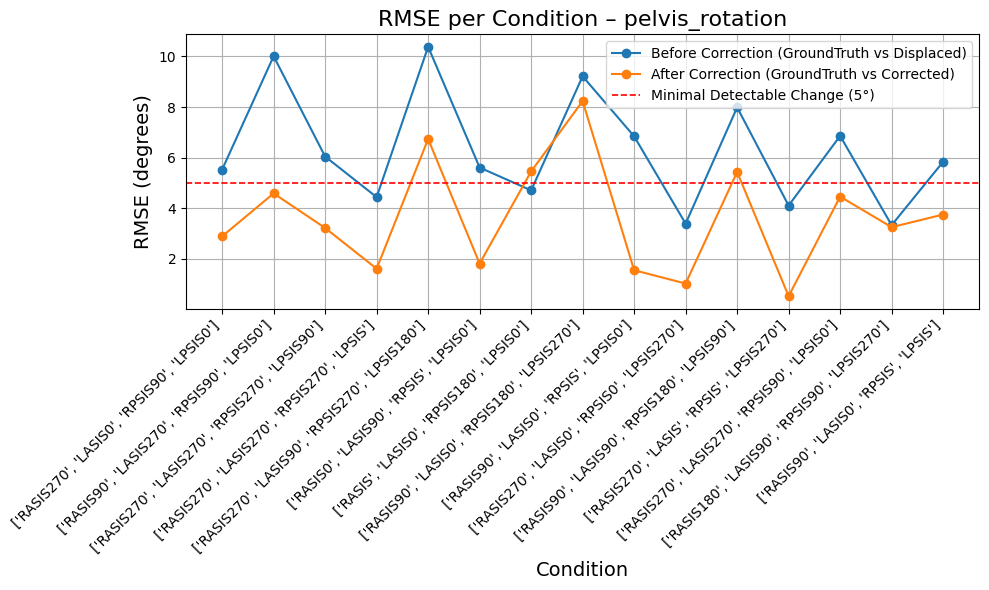


🟢 hip_flexion_r
  Mean BEFORE : 4.0227
  Mean AFTER  : 2.9356
  t-test    : t = 2.774, p = 0.0149 → Significant
  Wilcoxon  : W = 20.000, p = 0.0215 → Significant


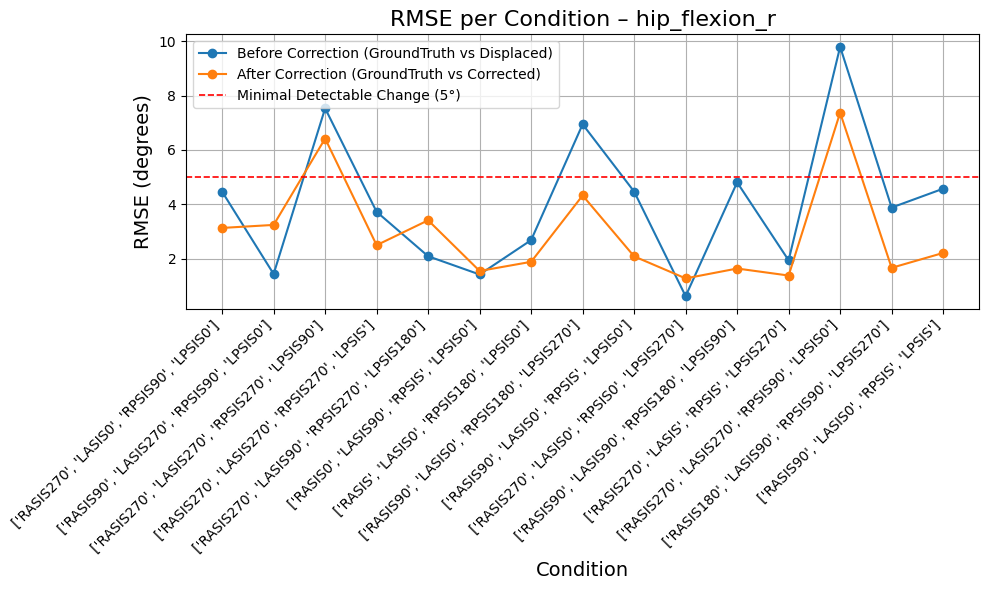


🟢 hip_adduction_r
  Mean BEFORE : 5.1693
  Mean AFTER  : 2.7749
  t-test    : t = 5.250, p = 0.0001 → Significant
  Wilcoxon  : W = 0.000, p = 0.0001 → Significant


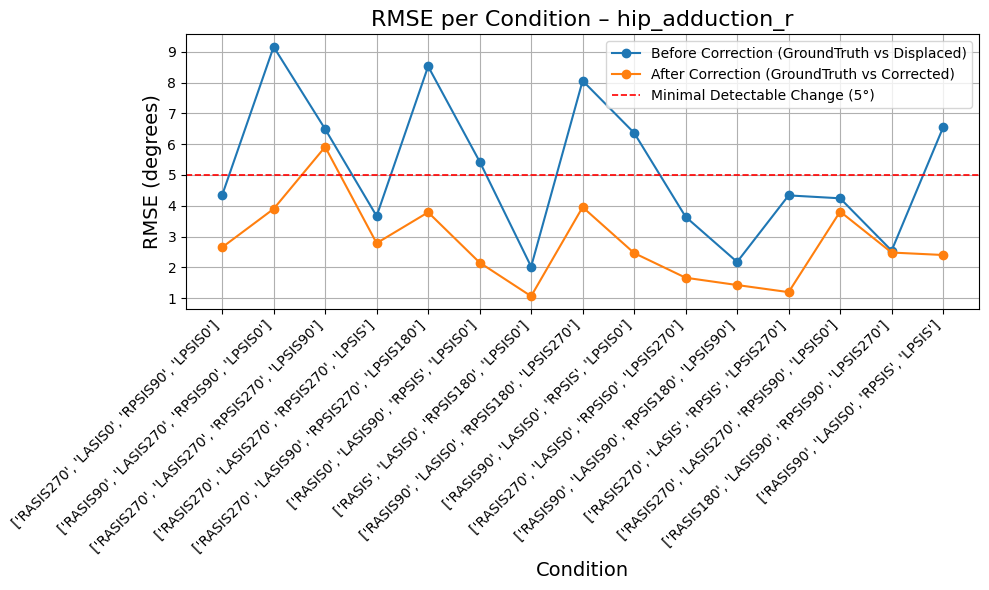


🟢 hip_rotation_r
  Mean BEFORE : 2.6612
  Mean AFTER  : 2.0024
  t-test    : t = 1.683, p = 0.1146 → Not significant
  Wilcoxon  : W = 34.000, p = 0.1514 → Not significant


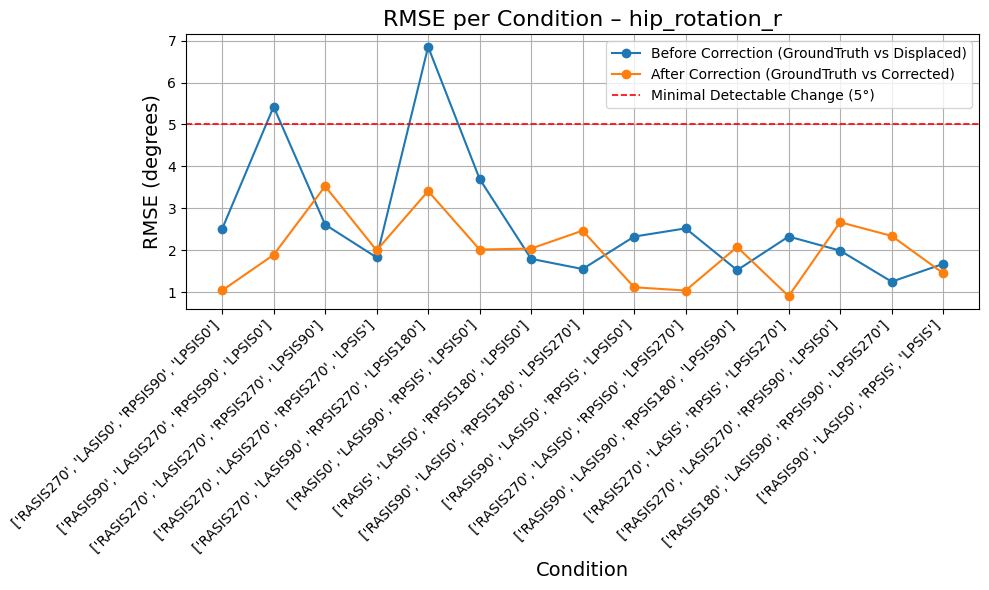


🟢 knee_angle_r
  Mean BEFORE : 2.0220
  Mean AFTER  : 1.6414
  t-test    : t = 2.950, p = 0.0106 → Significant
  Wilcoxon  : W = 18.000, p = 0.0151 → Significant


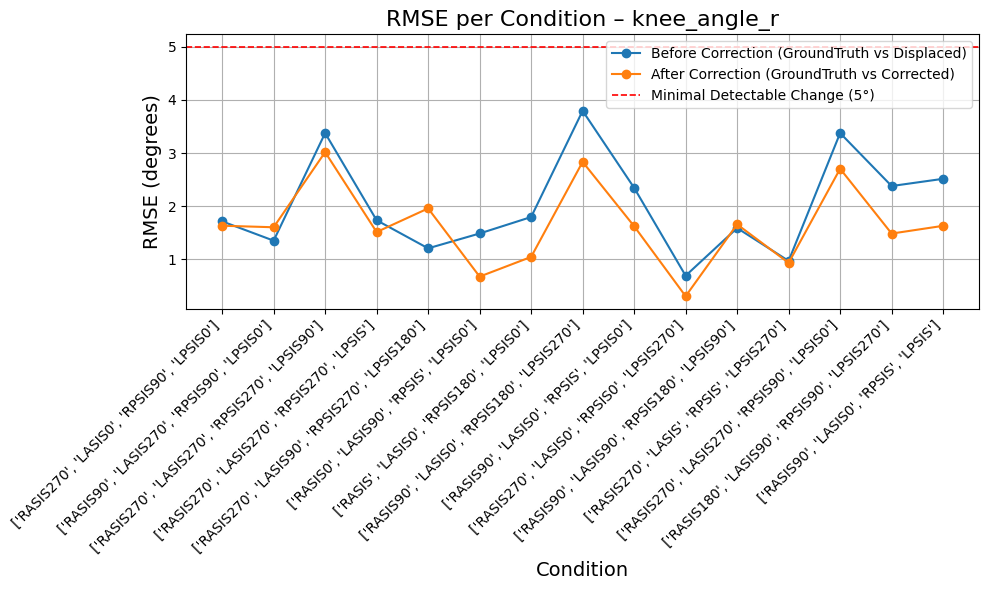


🟢 ankle_angle_r
  Mean BEFORE : 1.1825
  Mean AFTER  : 0.8497
  t-test    : t = 5.808, p = 0.0000 → Significant
  Wilcoxon  : W = 4.000, p = 0.0004 → Significant


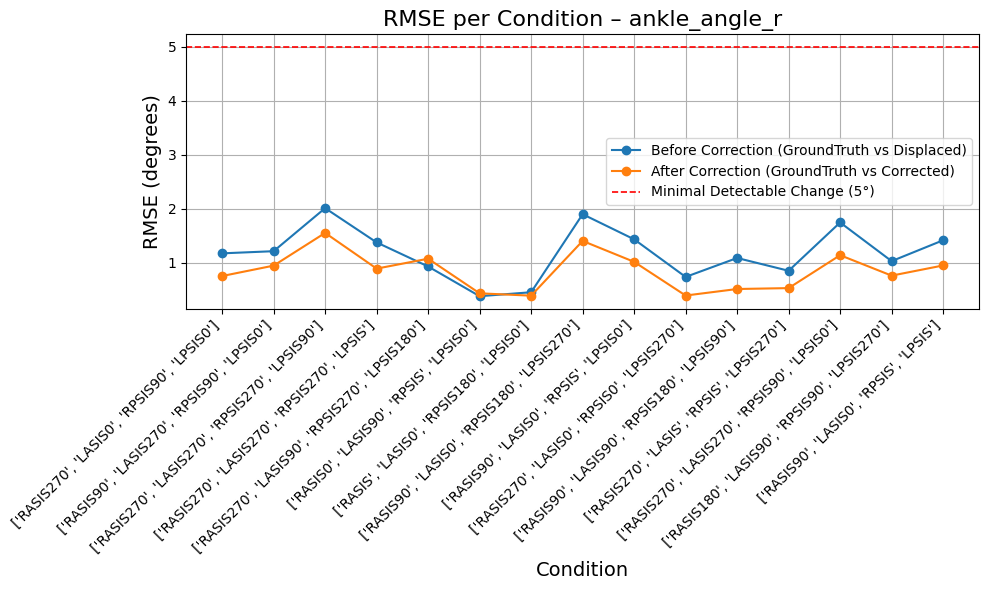


🟢 subtalar_angle_r
  Mean BEFORE : 2.0926
  Mean AFTER  : 1.4383
  t-test    : t = 4.728, p = 0.0003 → Significant
  Wilcoxon  : W = 5.000, p = 0.0006 → Significant


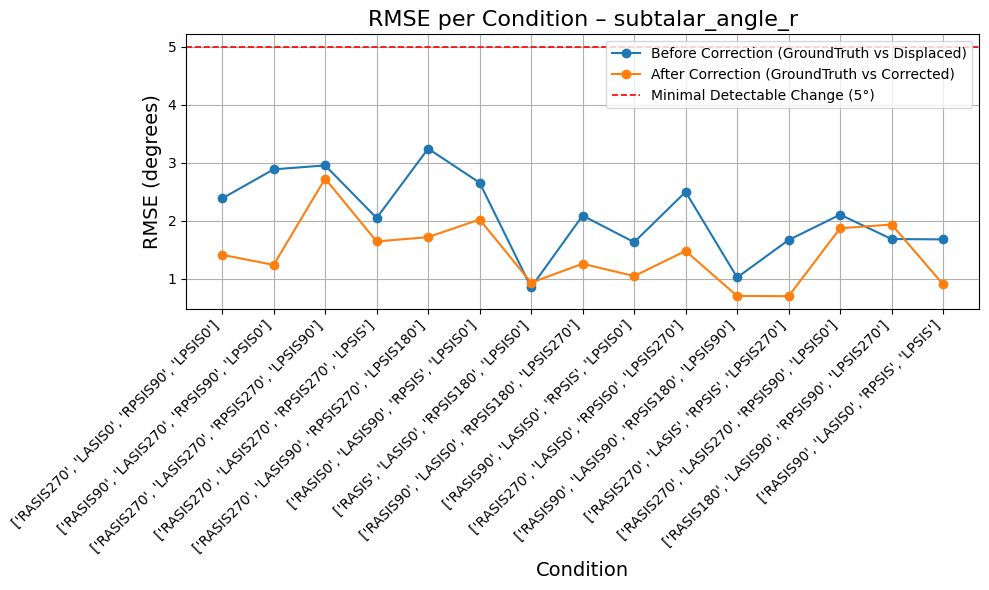


🟢 hip_flexion_l
  Mean BEFORE : 4.2256
  Mean AFTER  : 2.5529
  t-test    : t = 3.677, p = 0.0025 → Significant
  Wilcoxon  : W = 11.000, p = 0.0034 → Significant


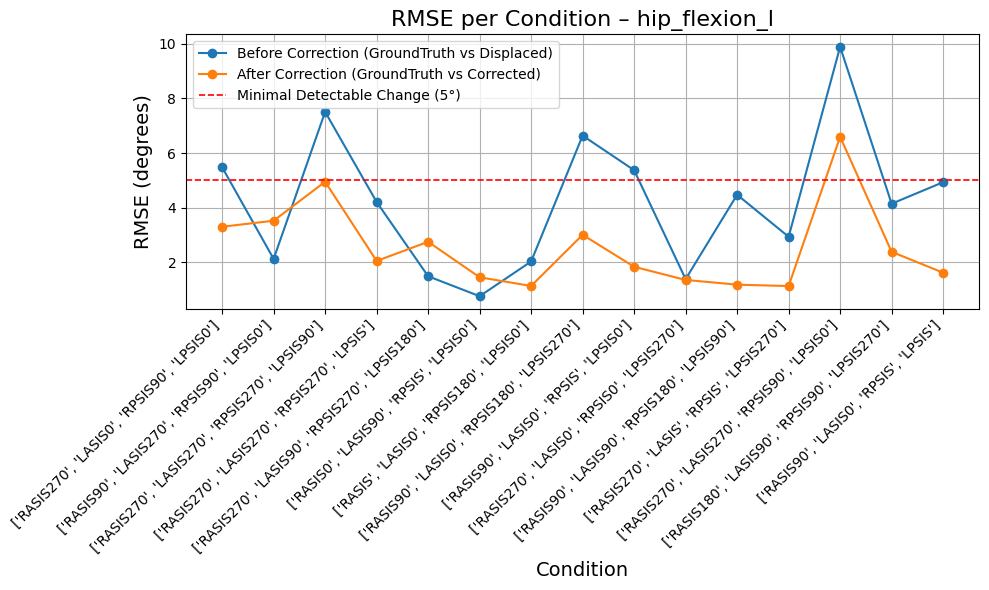


🟢 hip_adduction_l
  Mean BEFORE : 4.2663
  Mean AFTER  : 2.3484
  t-test    : t = 4.488, p = 0.0005 → Significant
  Wilcoxon  : W = 2.000, p = 0.0002 → Significant


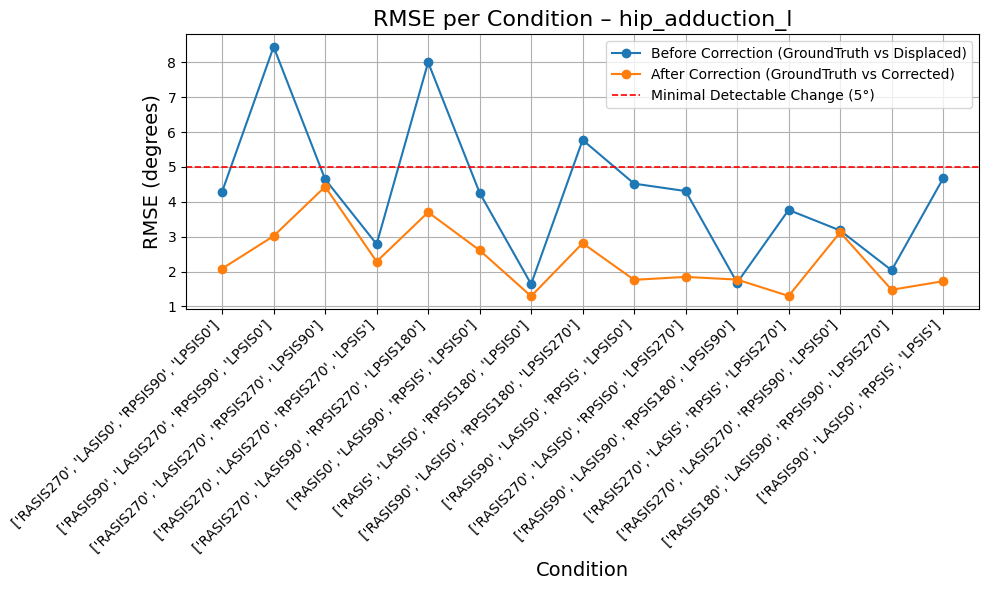


🟢 hip_rotation_l
  Mean BEFORE : 2.5658
  Mean AFTER  : 1.8070
  t-test    : t = 3.068, p = 0.0083 → Significant
  Wilcoxon  : W = 16.000, p = 0.0103 → Significant


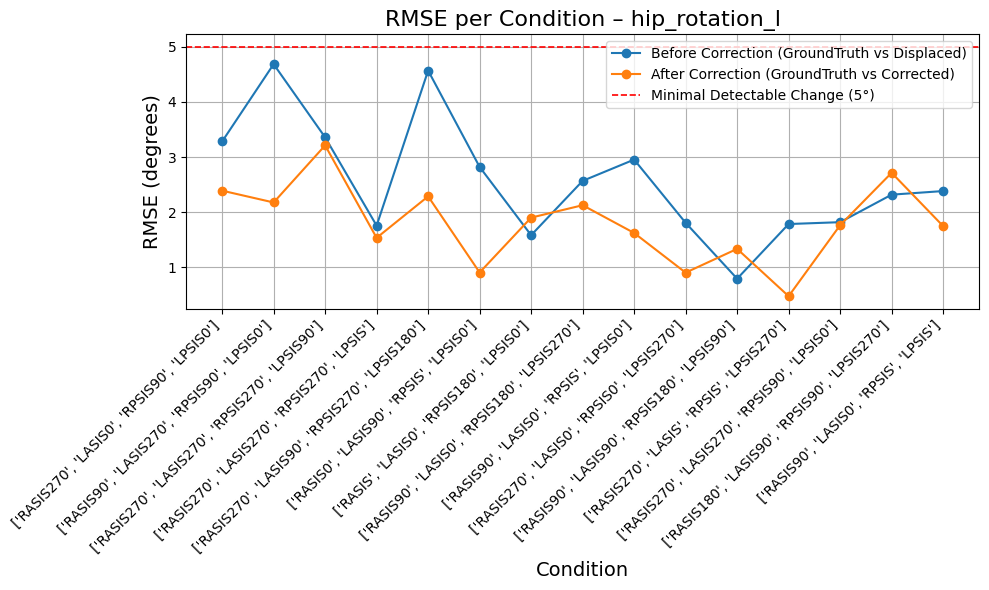


🟢 knee_angle_l
  Mean BEFORE : 1.6321
  Mean AFTER  : 1.2565
  t-test    : t = 2.281, p = 0.0387 → Significant
  Wilcoxon  : W = 26.000, p = 0.0554 → Not significant


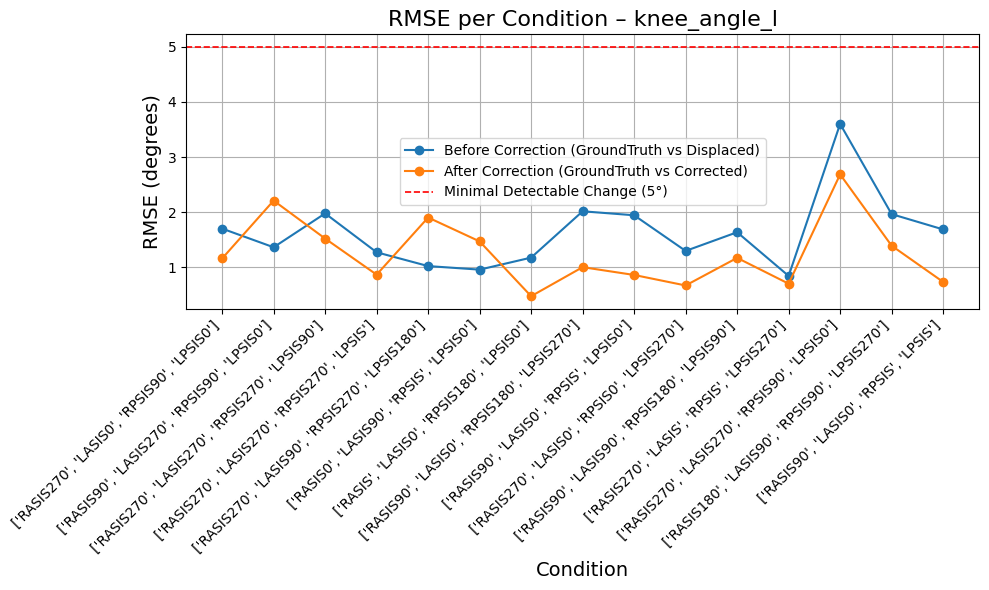


🟢 ankle_angle_l
  Mean BEFORE : 0.6734
  Mean AFTER  : 0.4956
  t-test    : t = 3.248, p = 0.0058 → Significant
  Wilcoxon  : W = 18.000, p = 0.0151 → Significant


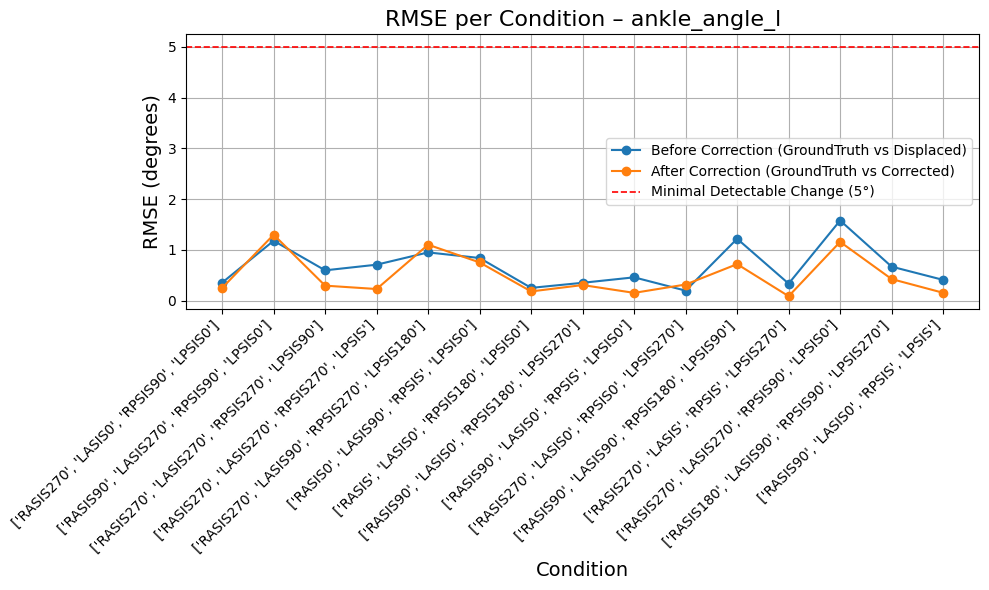


🟢 subtalar_angle_l
  Mean BEFORE : 1.9934
  Mean AFTER  : 1.6418
  t-test    : t = 3.837, p = 0.0018 → Significant
  Wilcoxon  : W = 9.000, p = 0.0020 → Significant


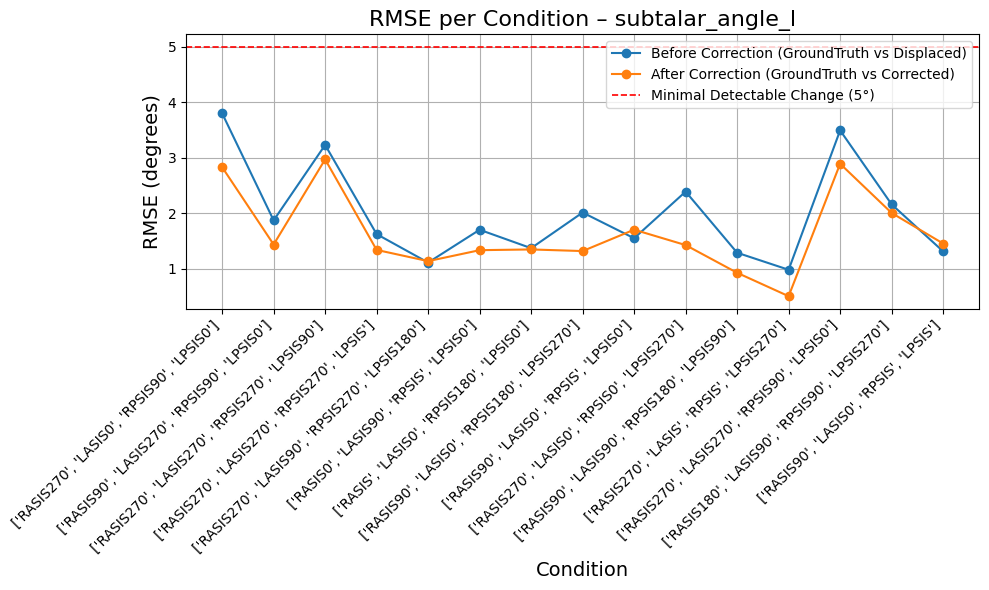


=== Summary Bar Chart: Mean RMSE Before vs After per Kinematic ===


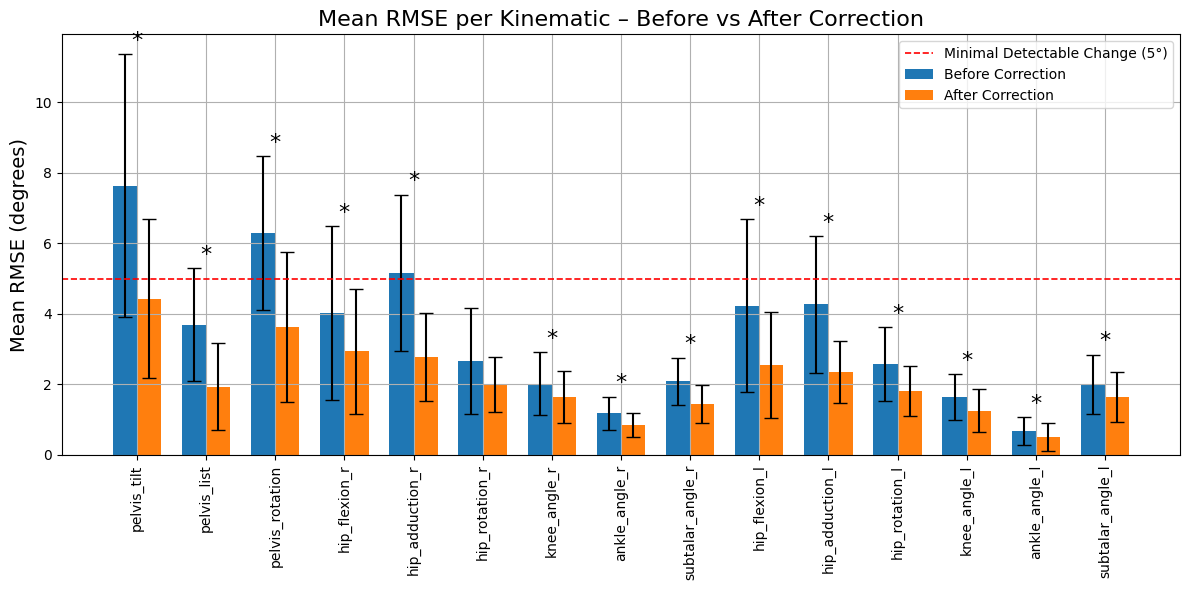

In [8]:
per_kin_b, per_kin_a, global_b, global_a = analyze_correction_effect_per_day_kinematics_(
    ground_truth_path=path_to_gt_point_kin_motion,
    files_before=displaced_pointkin_walk_motions,
    files_after=averaged_pointkin_walk_motions,
    kinematics_to_compare=KINEMATICS,
    combo_list=COMBOS
)